In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install imblearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn[1].csv')

In [3]:
df.rename(columns = {'SeniorCitizen':'senior_citizen', 'Partner':'partner', 'Dependents' :'dependents',
                     'PhoneService':'phone_service', 'MultipleLines':'multiple_lines', 'InternetService':'internet_service',
                     'OnlineSecurity':'online_security', 'OnlineBackup':'online_backup', 'DeviceProtection':'device_protection', 
                     'TechSupport':'tech_support', 'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies', 
                     'Contract':'contract', 'PaperlessBilling':'paperless_billing', 'PaymentMethod':'payment_method', 
                     'MonthlyCharges':'monthly_charges', 'TotalCharges':'total_charges', 'Churn':'churn'}, inplace = True) 
df.columns

Index(['customerID', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

In [4]:
df = df.drop('customerID', axis=1)
df.loc[ df['churn'] == "Yes", 'churn'] = 1
df.loc[ df['churn'] == "No", 'churn'] = 0
df = pd.get_dummies(df, columns=['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 
                                 'online_security',  'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 
                                 'streaming_movies', 'contract', 'paperless_billing', 'payment_method'], drop_first=True, dtype=int)
df

,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,...,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_One year,contract_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
0,0,1,29.85,29.85,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1889.5,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70.70,151.65,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.5,0,1,1,1,1,0,...,0,1,0,1,1,0,1,0,0,1
7039,0,72,103.20,7362.9,0,0,1,1,1,0,...,0,1,0,1,1,0,1,1,0,0
7040,0,11,29.60,346.45,0,0,1,1,0,1,...,0,0,0,0,0,0,1,0,1,0
7041,1,4,74.40,306.6,1,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [5]:
df = df.drop(df[df['total_charges'] == ' '].index)
df['total_charges'] = df['total_charges'].astype(float)

In [6]:
df.insert(0,'churnyeni',df['churn'])

In [7]:
df = df.drop('churn', axis=1)
df.rename(columns = {'churnyeni':'churn'}, inplace = True) 
df['churn'] = df['churn'].astype(int)

In [8]:
y=df['churn']


In [9]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [12,8], fontsize=16):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [12,8].
    fontsize: int
        Font size for axes labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="rocket")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [10]:
def evaluate_model(model, X, y, pred_label=1):

    """
    This function evaluates your model and interprets the classification metrics results in a DataFrame format.
    
    Input
    ---------
    model: Classification Model
    X: Features
    y: Label
    pred_label: Which label will be used for interprets the results
        
    Output
    -------
    metric_df: Result DataFrame
    """
    
    y_pred = model.predict(X)

    accuracy = round(accuracy_score(y, y_pred), 3)
    recall = round(recall_score(y, y_pred, pos_label = pred_label), 3)
    precision = round(precision_score(y, y_pred, pos_label = pred_label), 3)
    f1 = round(f1_score(y, y_pred, pos_label = pred_label), 3)
    auc_score = round(roc_auc_score(y, y_pred), 3)

    metric_df = pd.DataFrame([accuracy, recall, precision, f1, auc_score]).T
    metric_df.index = [ str(model) + "Class " + str(pred_label)]
    metric_df.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "AUC Score"]

    return metric_df

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:], y,
                                                    test_size=0.3, random_state=42)

In [12]:
rf = RandomForestClassifier()

acc_rf = cross_val_score(rf, x_train, y_train, cv=10, scoring='accuracy')

dt = DecisionTreeClassifier() 

acc_dt = cross_val_score(dt, x_train, y_train, cv=10, scoring='accuracy')

xgboost = XGBClassifier()

acc_xgboost = cross_val_score(xgboost, x_train, y_train, cv=10, scoring='accuracy')



In [13]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()

x_train_scaled = std_scale.fit_transform(x_train)
x_test_scaled = std_scale.transform(x_test)

In [14]:
logreg = LogisticRegression(solver='liblinear')

acc_logreg = cross_val_score(logreg, x_train_scaled, y_train, cv=10, scoring='accuracy')

knn = KNeighborsClassifier()

acc_knn = cross_val_score(knn, x_train_scaled, y_train, cv=10, scoring='accuracy')


perceptron = Perceptron()

acc_perc = cross_val_score(perceptron, x_train_scaled, y_train, cv=10, scoring='accuracy')

svc = SVC()

acc_svc = cross_val_score(svc, x_train_scaled, y_train, cv=10, scoring='accuracy')


In [15]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost',
              'Logistic Regression', 'KNN', 'Perceptron', 'SVC'],
    'Cross Validated Score (Mean)': [acc_rf.mean(), acc_dt.mean(), acc_xgboost.mean(), acc_logreg.mean(),
                                     acc_knn.mean(), acc_perc.mean(), acc_svc.mean()],
    'Cross Validated Score (Std)': [acc_rf.std(), acc_dt.std(), acc_xgboost.std(), acc_logreg.std(),
                                    acc_knn.std(), acc_perc.std(), acc_svc.std()]})

result_df = results.sort_values(by='Cross Validated Score (Mean)', ascending=False)
result_df = result_df.set_index('Model')
result_df['Cross Validated Score (Mean)'] = (result_df['Cross Validated Score (Mean)']*100).round(2)
result_df['Cross Validated Score (Std)'] = (result_df['Cross Validated Score (Std)']*100).round(2)
result_df

,Cross Validated Score (Mean),Cross Validated Score (Std)
Model,,
Logistic Regression,80.25,1.98
SVC,80.09,1.33
Random Forest,79.46,1.50
XGBoost,78.18,1.57
KNN,76.51,2.05
Perceptron,74.83,2.87
Decision Tree,73.49,2.55


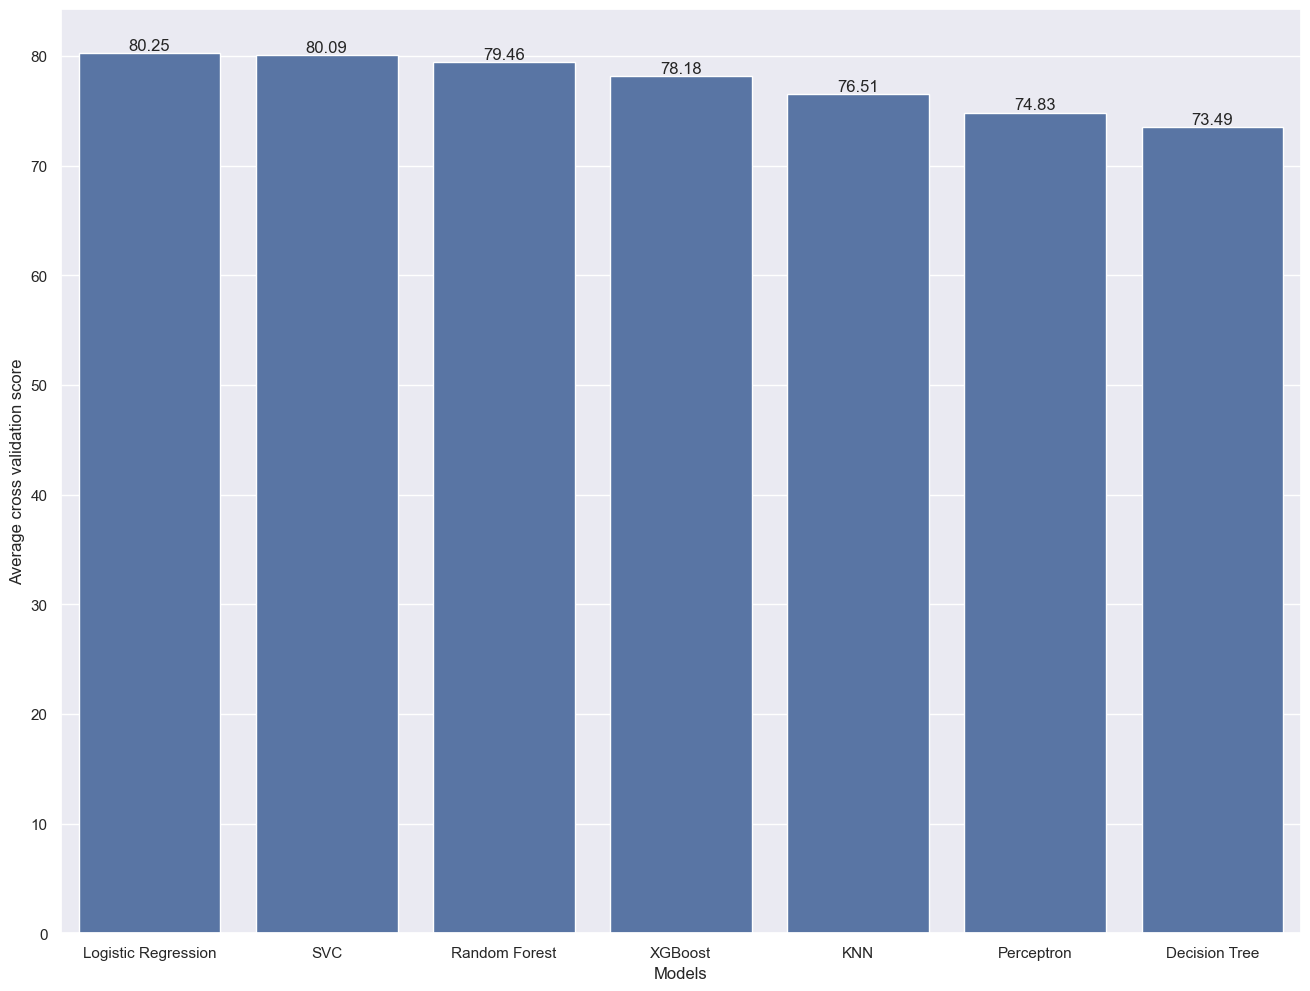

In [16]:
sns.set_theme(rc={'figure.figsize':(16,12)})
sns.color_palette("husl", 9)
ax = sns.barplot(x=result_df.index, y=result_df['Cross Validated Score (Mean)'], data=result_df);
ax.bar_label(ax.containers[0])
plt.xlabel('Models')
plt.ylabel('Average cross validation score')
plt.savefig("crossvalidation.png")

In [17]:
churn_rate = pd.DataFrame(df.churn.value_counts())
churn_rate

,count
churn,
0,5163
1,1869


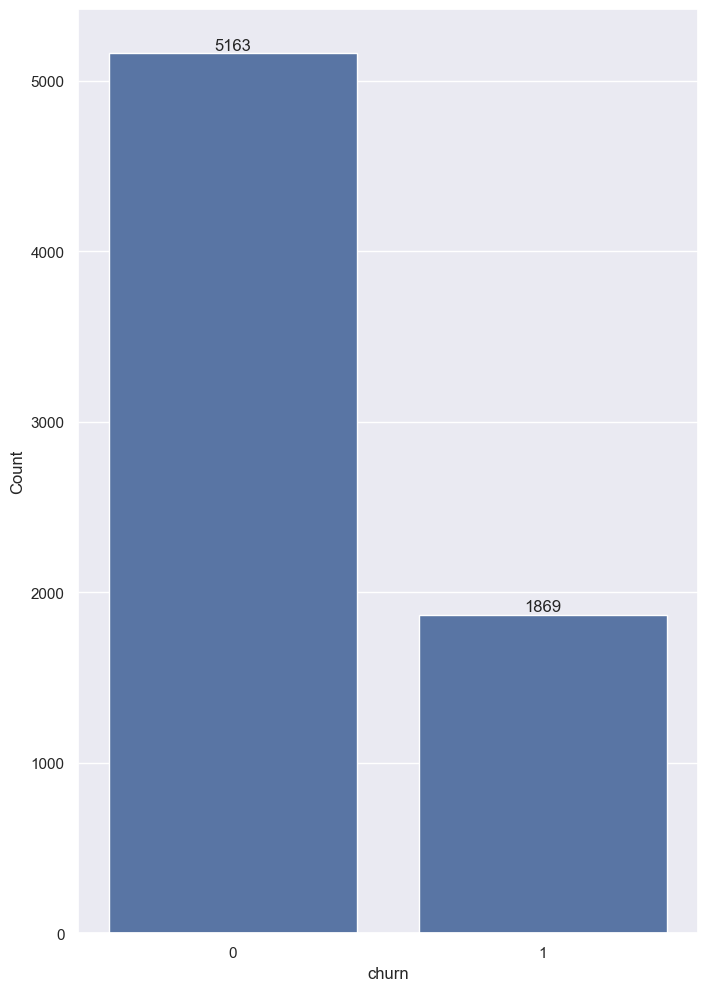

In [18]:
sns.set_theme(rc={'figure.figsize':(8,12)})
sns.color_palette("husl", 9)
ax = sns.barplot(x=churn_rate.index, y=churn_rate['count'], data=churn_rate);
ax.bar_label(ax.containers[0])
plt.xlabel('churn')
plt.ylabel('Count')
plt.savefig("churn.png")

In [19]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()

x_train_scaled = std_scale.fit_transform(x_train)
x_test_scaled = std_scale.transform(x_test)


In [20]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(x_train_scaled, y_train)


LogisticRegression(solver='liblinear')

In [21]:
evaluate_model(logreg, x_test_scaled, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 0,0.795,0.889,0.841,0.864,0.712


In [22]:
evaluate_model(logreg, x_test_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,0.795,0.535,0.636,0.581,0.712


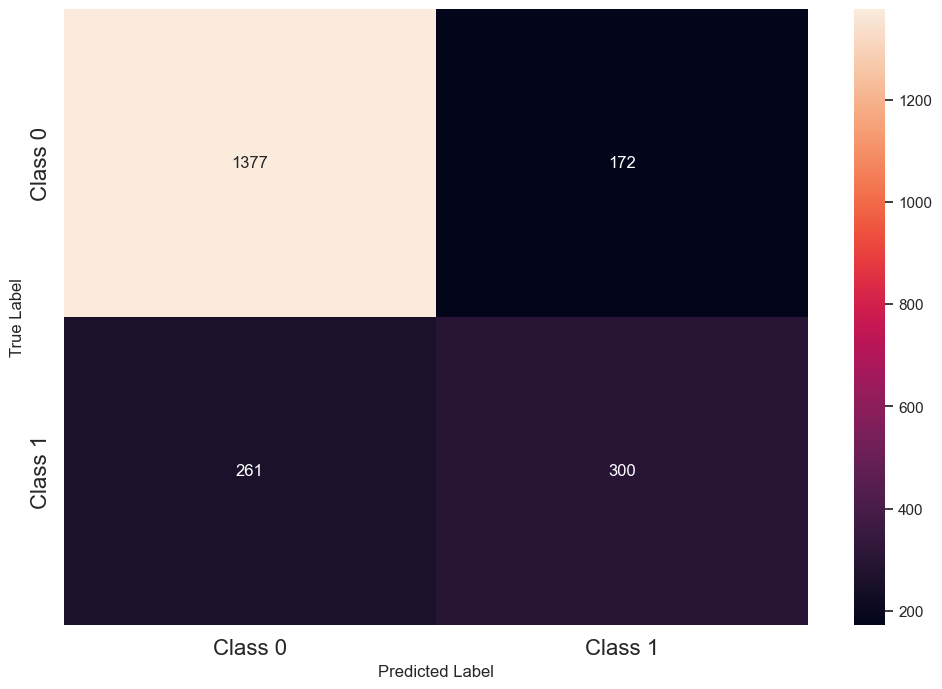

In [23]:
print_confusion_matrix(confusion_matrix(y_test, logreg.predict(x_test_scaled)), ['Class 0', 'Class 1'])

In [24]:
# random over sampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(x_train_scaled, y_train)
Counter(y_resampled)

Counter({1: 3614, 0: 3614})

In [25]:
xr_train, xr_test, yr_train, yr_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.3, random_state=42)

In [26]:
logreg_ros = LogisticRegression(solver='liblinear')
logreg_ros.fit(xr_train, yr_train)


LogisticRegression(solver='liblinear')

In [27]:
evaluate_model(logreg_ros, xr_test, yr_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 0,0.775,0.74,0.802,0.77,0.776


In [28]:
evaluate_model(logreg_ros, xr_test, yr_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,0.775,0.811,0.752,0.78,0.776


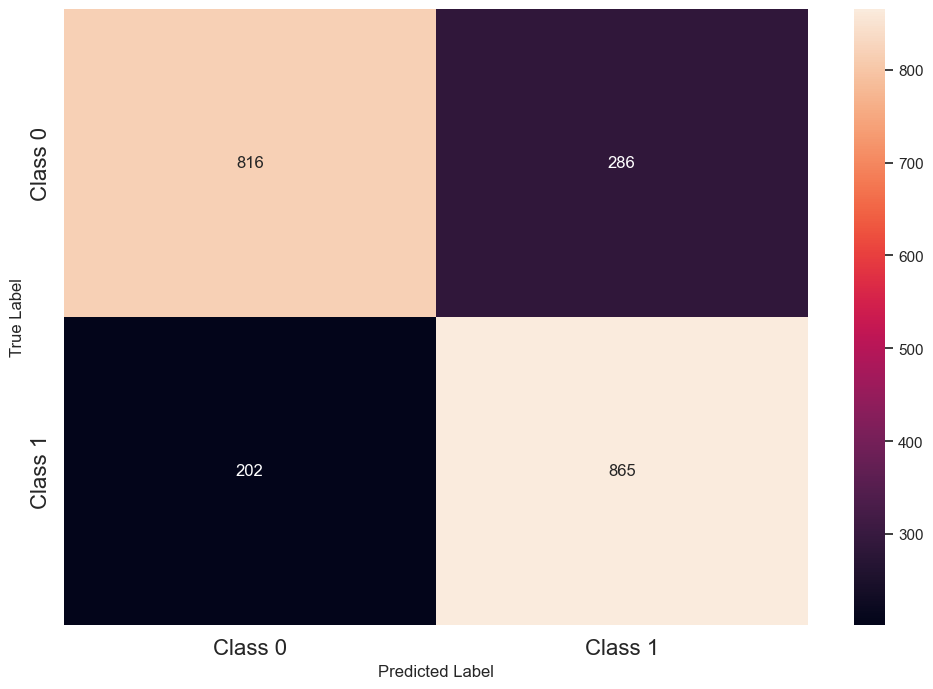

In [29]:
print_confusion_matrix(confusion_matrix(yr_test, logreg_ros.predict(xr_test)), ['Class 0', 'Class 1'])

In [30]:
xr_train, xr_test, yr_train, yr_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.3, random_state=42)

In [31]:
logreg_ros= LogisticRegression(solver='liblinear')
logreg_ros.fit(xr_train, yr_train)

LogisticRegression(solver='liblinear')

In [32]:
y_pred_logreg_ros = logreg_ros.predict(xr_test)

In [33]:
print(confusion_matrix(yr_test, y_pred_logreg_ros))

[[816 286]
 [202 865]]


In [34]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE().fit_resample(x_train_scaled, y_train)
Counter(y_smoted)

Counter({1: 3614, 0: 3614})

In [35]:
xs_train, xs_test, ys_train, ys_test = train_test_split(X_smoted, y_smoted,
                                                    test_size=0.3, random_state=42)

In [36]:
logreg_smote = LogisticRegression(solver='liblinear')
logreg_smote.fit(xs_train, ys_train)

LogisticRegression(solver='liblinear')

In [37]:
evaluate_model(logreg_smote, xs_test, ys_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 0,0.782,0.75,0.807,0.777,0.782


In [38]:
evaluate_model(logreg_smote, xs_test, ys_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,0.782,0.815,0.759,0.786,0.782


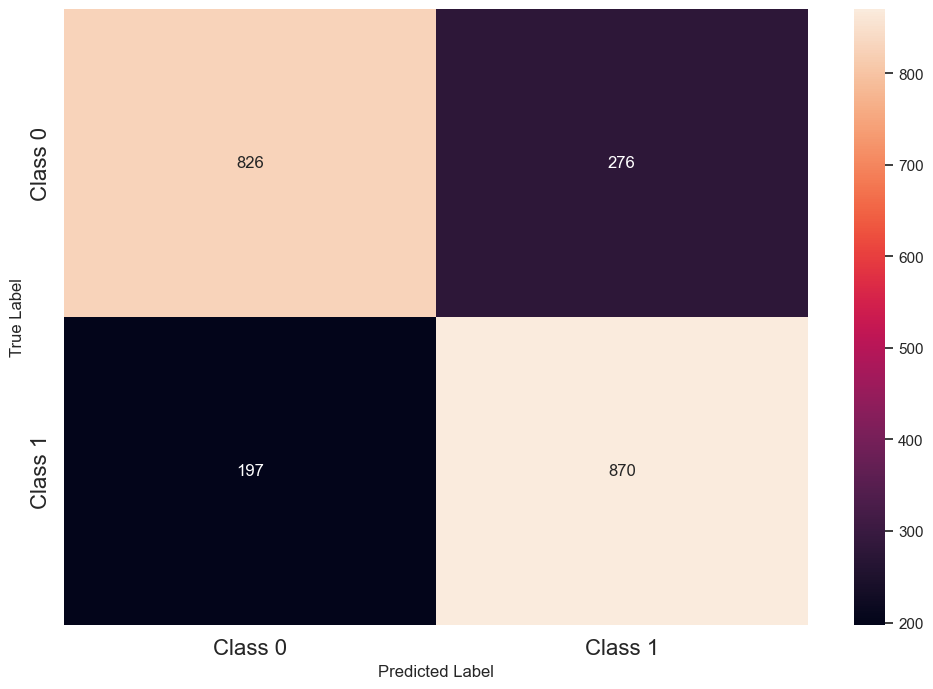

In [39]:
print_confusion_matrix(confusion_matrix(ys_test, logreg_smote.predict(xs_test)), ['Class 0', 'Class 1'])

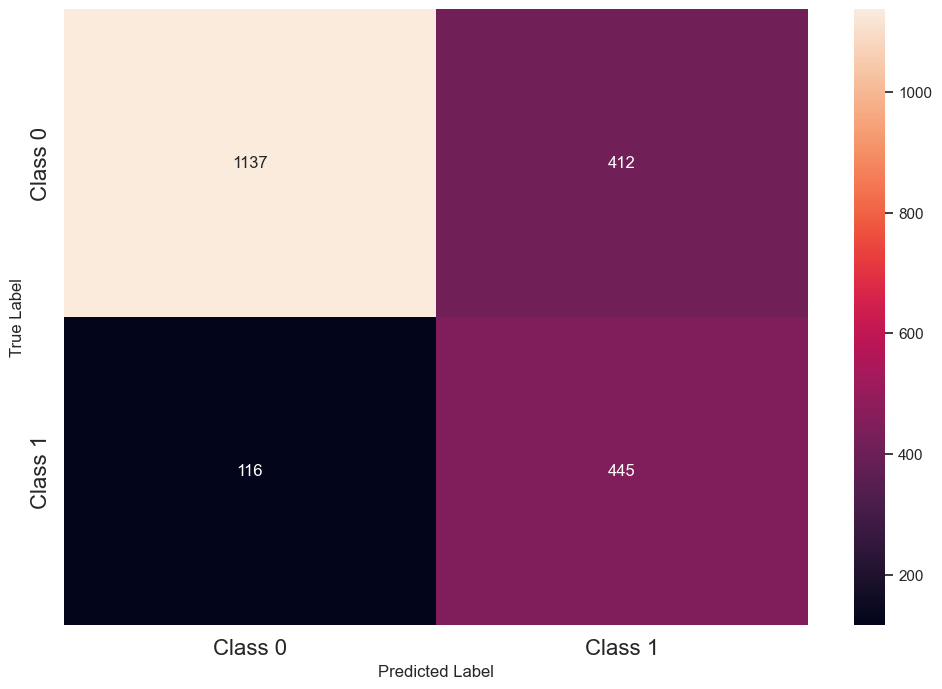

In [40]:
print_confusion_matrix(confusion_matrix(y_test, logreg_smote.predict(x_test_scaled)), ['Class 0', 'Class 1'])

In [41]:
logreg_smote_test0 = evaluate_model(logreg_smote, x_test_scaled, y_test, pred_label=0)

In [42]:
logreg_smote_test1 = evaluate_model(logreg_smote, x_test_scaled, y_test, pred_label=1)

In [43]:
# 
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(x_train_scaled, y_train)
Counter(y_adasyn)

Counter({0: 3614, 1: 3609})

In [44]:
xa_train, xa_test, ya_train, ya_test = train_test_split(X_adasyn, y_adasyn,
                                                    test_size=0.3, random_state=42)

In [45]:
logreg_adasyn = LogisticRegression(solver='liblinear')
logreg_adasyn.fit(xa_train, ya_train)

LogisticRegression(solver='liblinear')

In [46]:
evaluate_model(logreg_adasyn, xa_test, ya_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 0,0.752,0.706,0.776,0.739,0.752


In [47]:
evaluate_model(logreg_adasyn, xa_test, ya_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 0,0.752,0.706,0.776,0.739,0.752


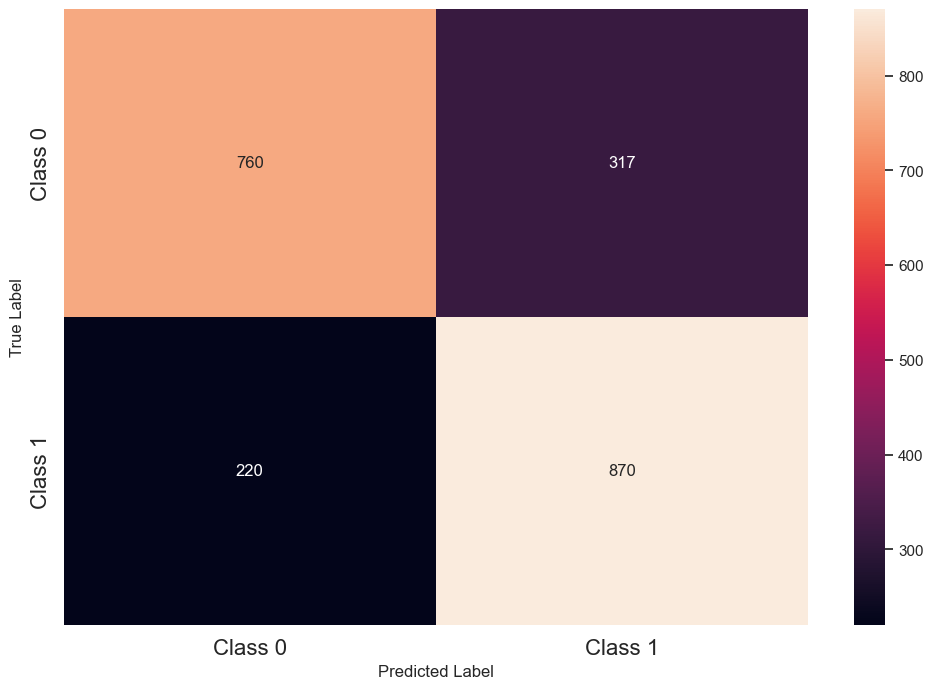

In [48]:
print_confusion_matrix(confusion_matrix(ya_test, logreg_adasyn.predict(xa_test)), ['Class 0', 'Class 1'])

In [49]:
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(x_train_scaled, y_train)

In [50]:
xb_train, xb_test, yb_train, yb_test = train_test_split(X_blsmote, y_blsmote,
                                                    test_size=0.3, random_state=42)

In [51]:
logreg_BorderlineSMOTE = LogisticRegression(solver='liblinear')
logreg_BorderlineSMOTE.fit(xb_train, yb_train)

LogisticRegression(solver='liblinear')

In [52]:
evaluate_model(logreg_BorderlineSMOTE, xb_test, yb_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 0,0.758,0.671,0.821,0.738,0.76


In [53]:
evaluate_model(logreg_BorderlineSMOTE, xb_test, yb_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,0.758,0.849,0.714,0.776,0.76


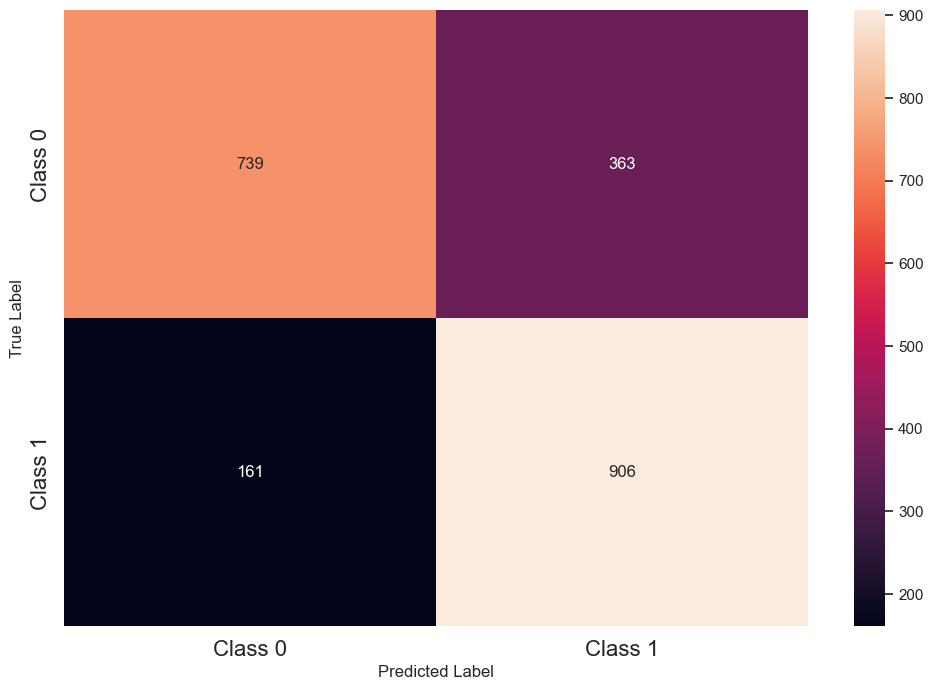

In [54]:
print_confusion_matrix(confusion_matrix(yb_test, logreg_BorderlineSMOTE.predict(xb_test)), ['Class 0', 'Class 1'])

In [55]:
logreg_train1 =evaluate_model(logreg, x_test_scaled, y_test, pred_label=1)

logreg_ros_train1 = evaluate_model(logreg_ros, xr_test, yr_test, pred_label=1)

logreg_smote_train1 = evaluate_model(logreg_smote, xs_test, ys_test, pred_label=1)

logreg_adasyn_train1 = evaluate_model(logreg_adasyn, xa_test, ya_test, pred_label=1)

logreg_BorderlineSMOTE_train1 =evaluate_model(logreg_BorderlineSMOTE, xb_test, yb_test, pred_label=1)




frames_logreg = [ logreg_train1, logreg_ros_train1,  logreg_smote_train1,  logreg_adasyn_train1, logreg_BorderlineSMOTE_train1]
frames_index_logreg = [ 'logreg_train1',  'logreg_ros_train1',  'logreg_smote_train1', 'logreg_adasyn_train1','logreg_BorderlineSMOTE_train1']


logreg_scores_train = pd.concat(frames_logreg)
logreg_scores_train.insert(0,'modeller', frames_index_logreg)
logreg_scores_train

,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,logreg_train1,0.795,0.535,0.636,0.581,0.712
LogisticRegression(solver='liblinear')Class 1,logreg_ros_train1,0.775,0.811,0.752,0.780,0.776
LogisticRegression(solver='liblinear')Class 1,logreg_smote_train1,0.782,0.815,0.759,0.786,0.782
LogisticRegression(solver='liblinear')Class 1,logreg_adasyn_train1,0.752,0.798,0.733,0.764,0.752
LogisticRegression(solver='liblinear')Class 1,logreg_BorderlineSMOTE_train1,0.758,0.849,0.714,0.776,0.760


In [56]:
logreg_test1 =evaluate_model(logreg, x_test_scaled, y_test, pred_label=1)

logreg_ros_test1 = evaluate_model(logreg_ros, x_test_scaled, y_test, pred_label=1)

logreg_smote_test1 = evaluate_model(logreg_smote, x_test_scaled, y_test, pred_label=1)

logreg_adasyn_test1 = evaluate_model(logreg_adasyn, x_test_scaled, y_test, pred_label=1)

logreg_BorderlineSMOTE_test1 =evaluate_model(logreg_BorderlineSMOTE, x_test_scaled, y_test, pred_label=1)




frames_logreg = [ logreg_test1,  logreg_ros_test1,  logreg_smote_test1,  logreg_adasyn_test1, logreg_BorderlineSMOTE_test1]
frames_index_logreg = ['logreg_test1',  'logreg_ros_test1',  'logreg_smote_test1', 'logreg_adasyn_test1','logreg_BorderlineSMOTE_test1']


logreg_scores_test = pd.concat(frames_logreg)
logreg_scores_test.insert(0,'modeller', frames_index_logreg)
logreg_scores_test 

,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,logreg_test1,0.795,0.535,0.636,0.581,0.712
LogisticRegression(solver='liblinear')Class 1,logreg_ros_test1,0.736,0.807,0.502,0.619,0.758
LogisticRegression(solver='liblinear')Class 1,logreg_smote_test1,0.750,0.793,0.519,0.628,0.764
LogisticRegression(solver='liblinear')Class 1,logreg_adasyn_test1,0.725,0.841,0.490,0.619,0.762
LogisticRegression(solver='liblinear')Class 1,logreg_BorderlineSMOTE_test1,0.713,0.877,0.479,0.619,0.765


# Random Forest Classifier

In [58]:
rf= RandomForestClassifier()
rf.fit(x_train, y_train)
evaluate_model(rf, x_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
RandomForestClassifier()Class 0,0.783,0.893,0.826,0.858,0.686


In [59]:
evaluate_model(rf, x_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
RandomForestClassifier()Class 1,0.783,0.48,0.62,0.541,0.686


In [60]:
ros = RandomOverSampler()
X_resampled_rf, y_resampled_rf = ros.fit_resample(x_train, y_train)
Counter(y_resampled)

Counter({1: 3614, 0: 3614})

In [61]:
xr_train_rf, xr_test_rf, yr_train_rf, yr_test_rf = train_test_split(X_resampled_rf, y_resampled_rf,
                                                    test_size=0.3, random_state=42)

In [62]:
rf_ros= RandomForestClassifier()
rf_ros.fit(xr_train_rf, yr_train_rf)

RandomForestClassifier()

In [63]:
X_smoted_rf, y_smoted_rf = SMOTE().fit_resample(x_train, y_train)
Counter(y_smoted_rf)
xs_train_rf, xs_test_rf, ys_train_rf, ys_test_rf = train_test_split(X_smoted_rf, y_smoted_rf,
                                                    test_size=0.3, random_state=42)
rf_smote= RandomForestClassifier()
rf_smote.fit(xs_train_rf, ys_train_rf)

RandomForestClassifier()

In [64]:
X_adasyn_rf, y_adasyn_rf = ADASYN().fit_resample(x_train, y_train)


In [65]:
xa_train_rf, xa_test_rf, ya_train_rf, ya_test_rf = train_test_split(X_adasyn_rf, y_adasyn_rf,
                                                    test_size=0.3, random_state=42)

In [66]:
rf_adasyn = RandomForestClassifier()
rf_adasyn.fit(xa_train_rf, ya_train_rf)

RandomForestClassifier()

In [67]:
X_blsmote_rf, y_blsmote_rf = BorderlineSMOTE().fit_resample(x_train, y_train)

In [68]:
xb_train_rf, xb_test_rf, yb_train_rf, yb_test_rf = train_test_split(X_blsmote_rf, y_blsmote_rf,
                                                    test_size=0.3, random_state=42)

In [69]:
rf_BorderlineSMOTE = RandomForestClassifier()
rf_BorderlineSMOTE.fit(xb_train_rf, yb_train_rf)

RandomForestClassifier()

In [70]:
rf_train1 =evaluate_model(rf, x_test, y_test, pred_label=1)

rf_ros_train1 = evaluate_model(rf_ros, xr_test_rf, yr_test_rf, pred_label=1)

rf_smote_train1 = evaluate_model(rf_smote, xs_test_rf, ys_test_rf, pred_label=1)

rf_adasyn_train1 = evaluate_model(rf_adasyn, xa_test_rf, ya_test_rf, pred_label=1)

rf_BorderlineSMOTE_train1 =evaluate_model(rf_BorderlineSMOTE, xb_test_rf, yb_test_rf, pred_label=1)




frames_rf = [ rf_train1,  rf_ros_train1,  rf_smote_train1,  rf_adasyn_train1, rf_BorderlineSMOTE_train1]
frames_index_rf = [ 'rf_train1',  'rf_ros_train1',  'rf_smote_train1',  'rf_adasyn_train1','rf_BorderlineSMOTE_train1']


rf_scores_train = pd.concat(frames_rf)
rf_scores_train.insert(0,'modeller', frames_index_rf)
rf_scores_train

,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
RandomForestClassifier()Class 1,rf_train1,0.783,0.480,0.620,0.541,0.686
RandomForestClassifier()Class 1,rf_ros_train1,0.890,0.947,0.848,0.895,0.891
RandomForestClassifier()Class 1,rf_smote_train1,0.844,0.854,0.833,0.844,0.844
RandomForestClassifier()Class 1,rf_adasyn_train1,0.843,0.866,0.827,0.846,0.844
RandomForestClassifier()Class 1,rf_BorderlineSMOTE_train1,0.847,0.863,0.832,0.847,0.847


In [71]:
rf_test1 =evaluate_model(rf, x_test, y_test, pred_label=1)

rf_ros_test1 = evaluate_model(rf_ros, x_test, y_test, pred_label=1)  

rf_smote_test1 = evaluate_model(rf_smote, x_test, y_test, pred_label=1)

rf_adasyn_test1 = evaluate_model(rf_adasyn, x_test, y_test, pred_label=1)

rf_BorderlineSMOTE_test1 =evaluate_model(rf_BorderlineSMOTE, x_test, y_test, pred_label=1)




frames_rf = [ rf_test1,  rf_ros_test1,  rf_smote_test1,  rf_adasyn_test1, rf_BorderlineSMOTE_test1]
frames_index_rf = [ 'rf_test1',  'rf_ros_test1',  'rf_smote_test1',  'rf_adasyn_test1','rf_BorderlineSMOTE_test1']


rf_scores_test = pd.concat(frames_rf)
rf_scores_test.insert(0,'modeller', frames_index_rf)
rf_scores_test

,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
RandomForestClassifier()Class 1,rf_test1,0.783,0.480,0.620,0.541,0.686
RandomForestClassifier()Class 1,rf_ros_test1,0.770,0.613,0.562,0.587,0.720
RandomForestClassifier()Class 1,rf_smote_test1,0.766,0.590,0.556,0.573,0.710
RandomForestClassifier()Class 1,rf_adasyn_test1,0.755,0.586,0.537,0.560,0.702
RandomForestClassifier()Class 1,rf_BorderlineSMOTE_test1,0.766,0.594,0.557,0.575,0.711


# SVC

In [73]:
svc = SVC()
svc.fit(x_train_scaled, y_train)
evaluate_model(svc, x_test_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
SVC()Class 1,0.792,0.483,0.647,0.553,0.694


In [74]:
ros = RandomOverSampler()
X_resampled_svc, y_resampled_svc = ros.fit_resample(x_train_scaled, y_train)
Counter(y_resampled_svc)

Counter({1: 3614, 0: 3614})

In [75]:
xr_train_svc, xr_test_svc, yr_train_svc, yr_test_svc = train_test_split(X_resampled_svc, y_resampled_svc,
                                                    test_size=0.3, random_state=42)

In [76]:
svc_ros= SVC()
svc_ros.fit(xr_train_svc, yr_train_svc)

SVC()

In [77]:
X_smoted_svc, y_smoted_svc = SMOTE().fit_resample(x_train_scaled, y_train)
Counter(y_smoted_svc)
xs_train_svc, xs_test_svc, ys_train_svc, ys_test_svc = train_test_split(X_smoted_svc, y_smoted_svc,
                                                    test_size=0.3, random_state=42)
svc_smote= SVC()
svc_smote.fit(xs_train_svc, ys_train_svc)

SVC()

In [78]:
X_adasyn_svc, y_adasyn_svc = ADASYN().fit_resample(x_train_scaled, y_train)
xa_train_svc, xa_test_svc, ya_train_svc, ya_test_svc = train_test_split(X_adasyn_svc, y_adasyn_svc,
                                                    test_size=0.3, random_state=42)

In [79]:
svc_adasyn = SVC()
svc_adasyn.fit(xa_train_svc, ya_train_svc)

SVC()

In [80]:
X_blsmote_svc, y_blsmote_svc = BorderlineSMOTE().fit_resample(x_train_scaled, y_train)
xb_train_svc, xb_test_svc, yb_train_svc, yb_test_svc = train_test_split(X_blsmote_svc, y_blsmote_svc,
                                                    test_size=0.3, random_state=42)
svc_BorderlineSMOTE = SVC()
svc_BorderlineSMOTE.fit(xb_train_svc, yb_train_svc)

SVC()

In [81]:
svc_train1 =evaluate_model(svc, x_test_scaled, y_test, pred_label=1)

svc_ros_train1 = evaluate_model(svc_ros, xr_test_svc, yr_test_svc, pred_label=1)

svc_smote_train1 = evaluate_model(svc_smote, xs_test_svc, ys_test_svc, pred_label=1)

svc_adasyn_train1 = evaluate_model(svc_adasyn, xa_test_svc, ya_test_svc, pred_label=1)

svc_BorderlineSMOTE_train1 =evaluate_model(svc_BorderlineSMOTE, xb_test_svc, yb_test_svc, pred_label=1)




frames_svc = [ svc_train1, svc_ros_train1,  svc_smote_train1,  svc_adasyn_train1, svc_BorderlineSMOTE_train1]
frames_index_svc = [ 'svc_train1', 'svc_ros_train1',  'svc_smote_train1',  'svc_adasyn_train1','svc_BorderlineSMOTE_train1']


svc_scores_train = pd.concat(frames_svc)
svc_scores_train.insert(0,'modeller', frames_index_svc)
svc_scores_train


,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
SVC()Class 1,svc_train1,0.792,0.483,0.647,0.553,0.694
SVC()Class 1,svc_ros_train1,0.788,0.816,0.768,0.791,0.789
SVC()Class 1,svc_smote_train1,0.813,0.846,0.789,0.816,0.813
SVC()Class 1,svc_adasyn_train1,0.793,0.872,0.755,0.809,0.792
SVC()Class 1,svc_BorderlineSMOTE_train1,0.806,0.908,0.750,0.822,0.808


In [82]:
svc_test1 =evaluate_model(svc, x_test_scaled, y_test, pred_label=1)

svc_ros_test1 = evaluate_model(svc_ros, x_test_scaled, y_test, pred_label=1)

svc_smote_test1 = evaluate_model(svc_smote, x_test_scaled, y_test, pred_label=1)

svc_adasyn_test1 = evaluate_model(svc_adasyn, x_test_scaled, y_test, pred_label=1)

svc_BorderlineSMOTE_test1 =evaluate_model(svc_BorderlineSMOTE, x_test_scaled, y_test, pred_label=1)




frames_svc = [ svc_test1,  svc_ros_test1,  svc_smote_test1,  svc_adasyn_test1 ,svc_BorderlineSMOTE_test1]
frames_index_svc = [ 'svc_test1',  'svc_ros_test1',  'svc_smote_test1',  'svc_adasyn_test1', 'svc_BorderlineSMOTE_test1']


svc_scores_test = pd.concat(frames_svc)
svc_scores_test.insert(0,'modeller', frames_index_svc)
svc_scores_test


,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
SVC()Class 1,svc_test1,0.792,0.483,0.647,0.553,0.694
SVC()Class 1,svc_ros_test1,0.742,0.754,0.510,0.609,0.746
SVC()Class 1,svc_smote_test1,0.760,0.734,0.535,0.619,0.752
SVC()Class 1,svc_adasyn_test1,0.727,0.775,0.492,0.602,0.742
SVC()Class 1,svc_BorderlineSMOTE_test1,0.718,0.790,0.481,0.598,0.741


In [83]:
evaluate_model(svc_BorderlineSMOTE, x_test_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
SVC()Class 1,0.718,0.79,0.481,0.598,0.741


# XGBOOST

In [85]:
xgboost = XGBClassifier()
xgboost.fit(x_train, y_train)
evaluate_model(xgboost, x_test, y_test, pred_label=0)

ros = RandomOverSampler()
X_resampled_xgboost, y_resampled_xgboost = ros.fit_resample(x_train, y_train)
Counter(y_resampled)

xr_train_xgboost, xr_test_xgboost, yr_train_xgboost, yr_test_xgboost = train_test_split(X_resampled_xgboost, y_resampled_xgboost,
                                                    test_size=0.3, random_state=42)

xgboost_ros= XGBClassifier()
xgboost_ros.fit(xr_train_xgboost, yr_train_xgboost)

X_smoted_xgboost, y_smoted_xgboost = SMOTE().fit_resample(x_train, y_train)
Counter(y_smoted_xgboost)
xs_train_xgboost, xs_test_xgboost, ys_train_xgboost, ys_test_xgboost = train_test_split(X_smoted_xgboost, y_smoted_xgboost,
                                                    test_size=0.3, random_state=42)
xgboost_smote= XGBClassifier()
xgboost_smote.fit(xs_train_xgboost, ys_train_xgboost)

X_adasyn_xgboost, y_adasyn_xgboost = ADASYN().fit_resample(x_train, y_train)

xa_train_xgboost, xa_test_xgboost, ya_train_xgboost, ya_test_xgboost = train_test_split(X_adasyn_xgboost, y_adasyn_xgboost,
                                                    test_size=0.3, random_state=42)
xgboost_adasyn = XGBClassifier()
xgboost_adasyn.fit(xa_train_xgboost, ya_train_xgboost)
X_blsmote_xgboost, y_blsmote_xgboost = BorderlineSMOTE().fit_resample(x_train, y_train)
xb_train_xgboost, xb_test_xgboost, yb_train_xgboost, yb_test_xgboost = train_test_split(X_blsmote_xgboost, y_blsmote_xgboost,
                                                    test_size=0.3, random_state=42)
xgboost_BorderlineSMOTE = XGBClassifier()
xgboost_BorderlineSMOTE.fit(xb_train_xgboost, yb_train_xgboost)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [86]:
xgboost_train1 =evaluate_model(xgboost, x_test, y_test, pred_label=1)

xgboost_ros_train1 = evaluate_model(xgboost_ros, xr_test_xgboost, yr_test_xgboost, pred_label=1)

xgboost_smote_train1 = evaluate_model(xgboost_smote, xs_test_xgboost, ys_test_xgboost, pred_label=1)

xgboost_adasyn_train1 = evaluate_model(xgboost_adasyn, xa_test_xgboost, ya_test_xgboost, pred_label=1)

xgboost_BorderlineSMOTE_train1 =evaluate_model(xgboost_BorderlineSMOTE, xb_test_xgboost, yb_test_xgboost, pred_label=1)




frames_xgboost = [ xgboost_train1, xgboost_ros_train1,  xgboost_smote_train1,  xgboost_adasyn_train1, xgboost_BorderlineSMOTE_train1]
frames_index_xgboost = [ 'xgboost_train1', 'xgboost_ros_train1',  'xgboost_smote_train1', 'xgboost_adasyn_train1','xgboost_BorderlineSMOTE_train1']


xgboost_scores_train = pd.concat(frames_xgboost)
xgboost_scores_train.insert(0,'modeller', frames_index_xgboost)
xgboost_scores_train


,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_train1,0.769,0.515,0.573,0.543,0.688
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_ros_train1,0.862,0.919,0.822,0.868,0.863
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_smote_train1,0.848,0.864,0.833,0.848,0.848
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_adasyn_train1,0.844,0.862,0.830,0.845,0.844
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_BorderlineSMOTE_train1,0.856,0.878,0.837,0.857,0.857


In [87]:
xgboost_test1 =evaluate_model(xgboost, x_test, y_test, pred_label=1)

xgboost_ros_test1 = evaluate_model(xgboost_ros, x_test, y_test, pred_label=1)

xgboost_smote_test1 = evaluate_model(xgboost_smote, x_test, y_test, pred_label=1)

xgboost_adasyn_test1 = evaluate_model(xgboost_adasyn, x_test, y_test, pred_label=1)

xgboost_BorderlineSMOTE_test1 =evaluate_model(xgboost_BorderlineSMOTE, x_test, y_test, pred_label=1)




frames_xgboost = [ xgboost_test1,  xgboost_ros_test1,  xgboost_smote_test1,  xgboost_adasyn_test1 ,xgboost_BorderlineSMOTE_test1]
frames_index_xgboost = [ 'xgboost_test1',  'xgboost_ros_test1',  'xgboost_smote_test1',  'xgboost_adasyn_test1','xgboost_BorderlineSMOTE_test1']


xgboost_scores_test = pd.concat(frames_xgboost)
xgboost_scores_test.insert(0,'modeller', frames_index_xgboost)
xgboost_scores_test


,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_test1,0.769,0.515,0.573,0.543,0.688
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_ros_test1,0.752,0.672,0.526,0.590,0.726
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_smote_test1,0.764,0.597,0.551,0.573,0.710
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_adasyn_test1,0.749,0.578,0.525,0.550,0.694
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_BorderlineSMOTE_test1,0.760,0.604,0.544,0.573,0.710


In [88]:
train_scores = pd.concat([logreg_scores_train, rf_scores_train,svc_scores_train,xgboost_scores_train], axis=0)
train_scores.reset_index(drop=True, inplace=True)
train_scores

,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
0,logreg_train1,0.795,0.535,0.636,0.581,0.712
1,logreg_ros_train1,0.775,0.811,0.752,0.780,0.776
2,logreg_smote_train1,0.782,0.815,0.759,0.786,0.782
3,logreg_adasyn_train1,0.752,0.798,0.733,0.764,0.752
4,logreg_BorderlineSMOTE_train1,0.758,0.849,0.714,0.776,0.760
5,rf_train1,0.783,0.480,0.620,0.541,0.686
6,rf_ros_train1,0.890,0.947,0.848,0.895,0.891
7,rf_smote_train1,0.844,0.854,0.833,0.844,0.844
8,rf_adasyn_train1,0.843,0.866,0.827,0.846,0.844
9,rf_BorderlineSMOTE_train1,0.847,0.863,0.832,0.847,0.847


In [89]:
test_scores = pd.concat([logreg_scores_test, rf_scores_test,svc_scores_test,xgboost_scores_test], axis=0)

In [90]:
test_scores.sort_values(by=['AUC Score'], ascending=False, inplace=True)
test_scores

,modeller,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,logreg_BorderlineSMOTE_test1,0.713,0.877,0.479,0.619,0.765
LogisticRegression(solver='liblinear')Class 1,logreg_smote_test1,0.750,0.793,0.519,0.628,0.764
LogisticRegression(solver='liblinear')Class 1,logreg_adasyn_test1,0.725,0.841,0.490,0.619,0.762
LogisticRegression(solver='liblinear')Class 1,logreg_ros_test1,0.736,0.807,0.502,0.619,0.758
SVC()Class 1,svc_smote_test1,0.760,0.734,0.535,0.619,0.752
SVC()Class 1,svc_ros_test1,0.742,0.754,0.510,0.609,0.746
SVC()Class 1,svc_adasyn_test1,0.727,0.775,0.492,0.602,0.742
SVC()Class 1,svc_BorderlineSMOTE_test1,0.718,0.790,0.481,0.598,0.741
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)Class 1",xgboost_ros_test1,0.752,0.672,0.526,0.590,0.726
RandomForestClassifier()Class 1,rf_ros_test1,0.770,0.613,0.562,0.587,0.720


In [91]:
test_scores.reset_index(drop=True, inplace=True)

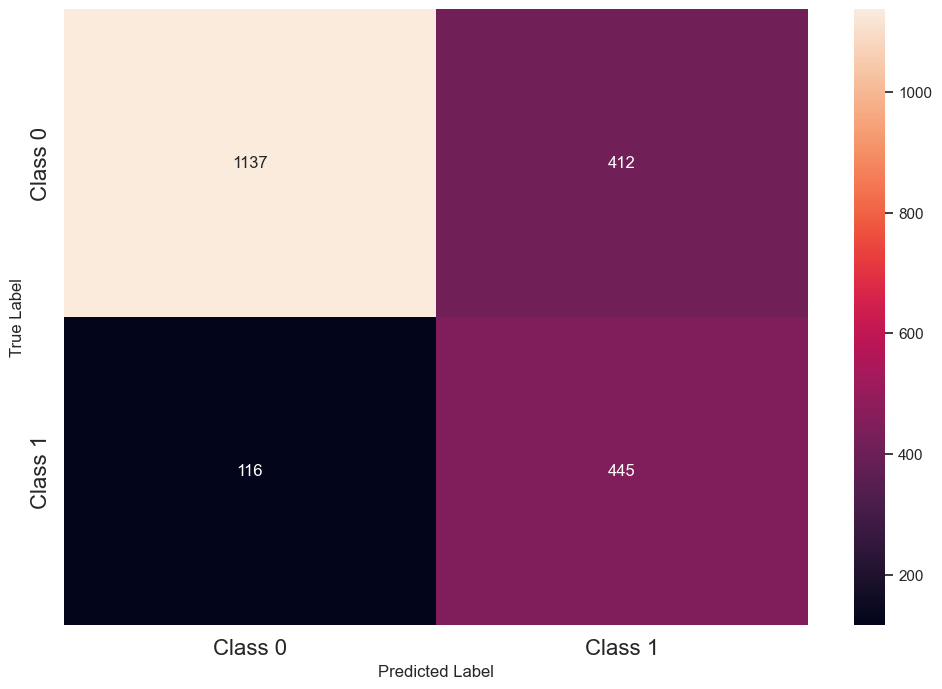

In [92]:
print_confusion_matrix(confusion_matrix(y_test, logreg_smote.predict(x_test_scaled)), ['Class 0', 'Class 1'])

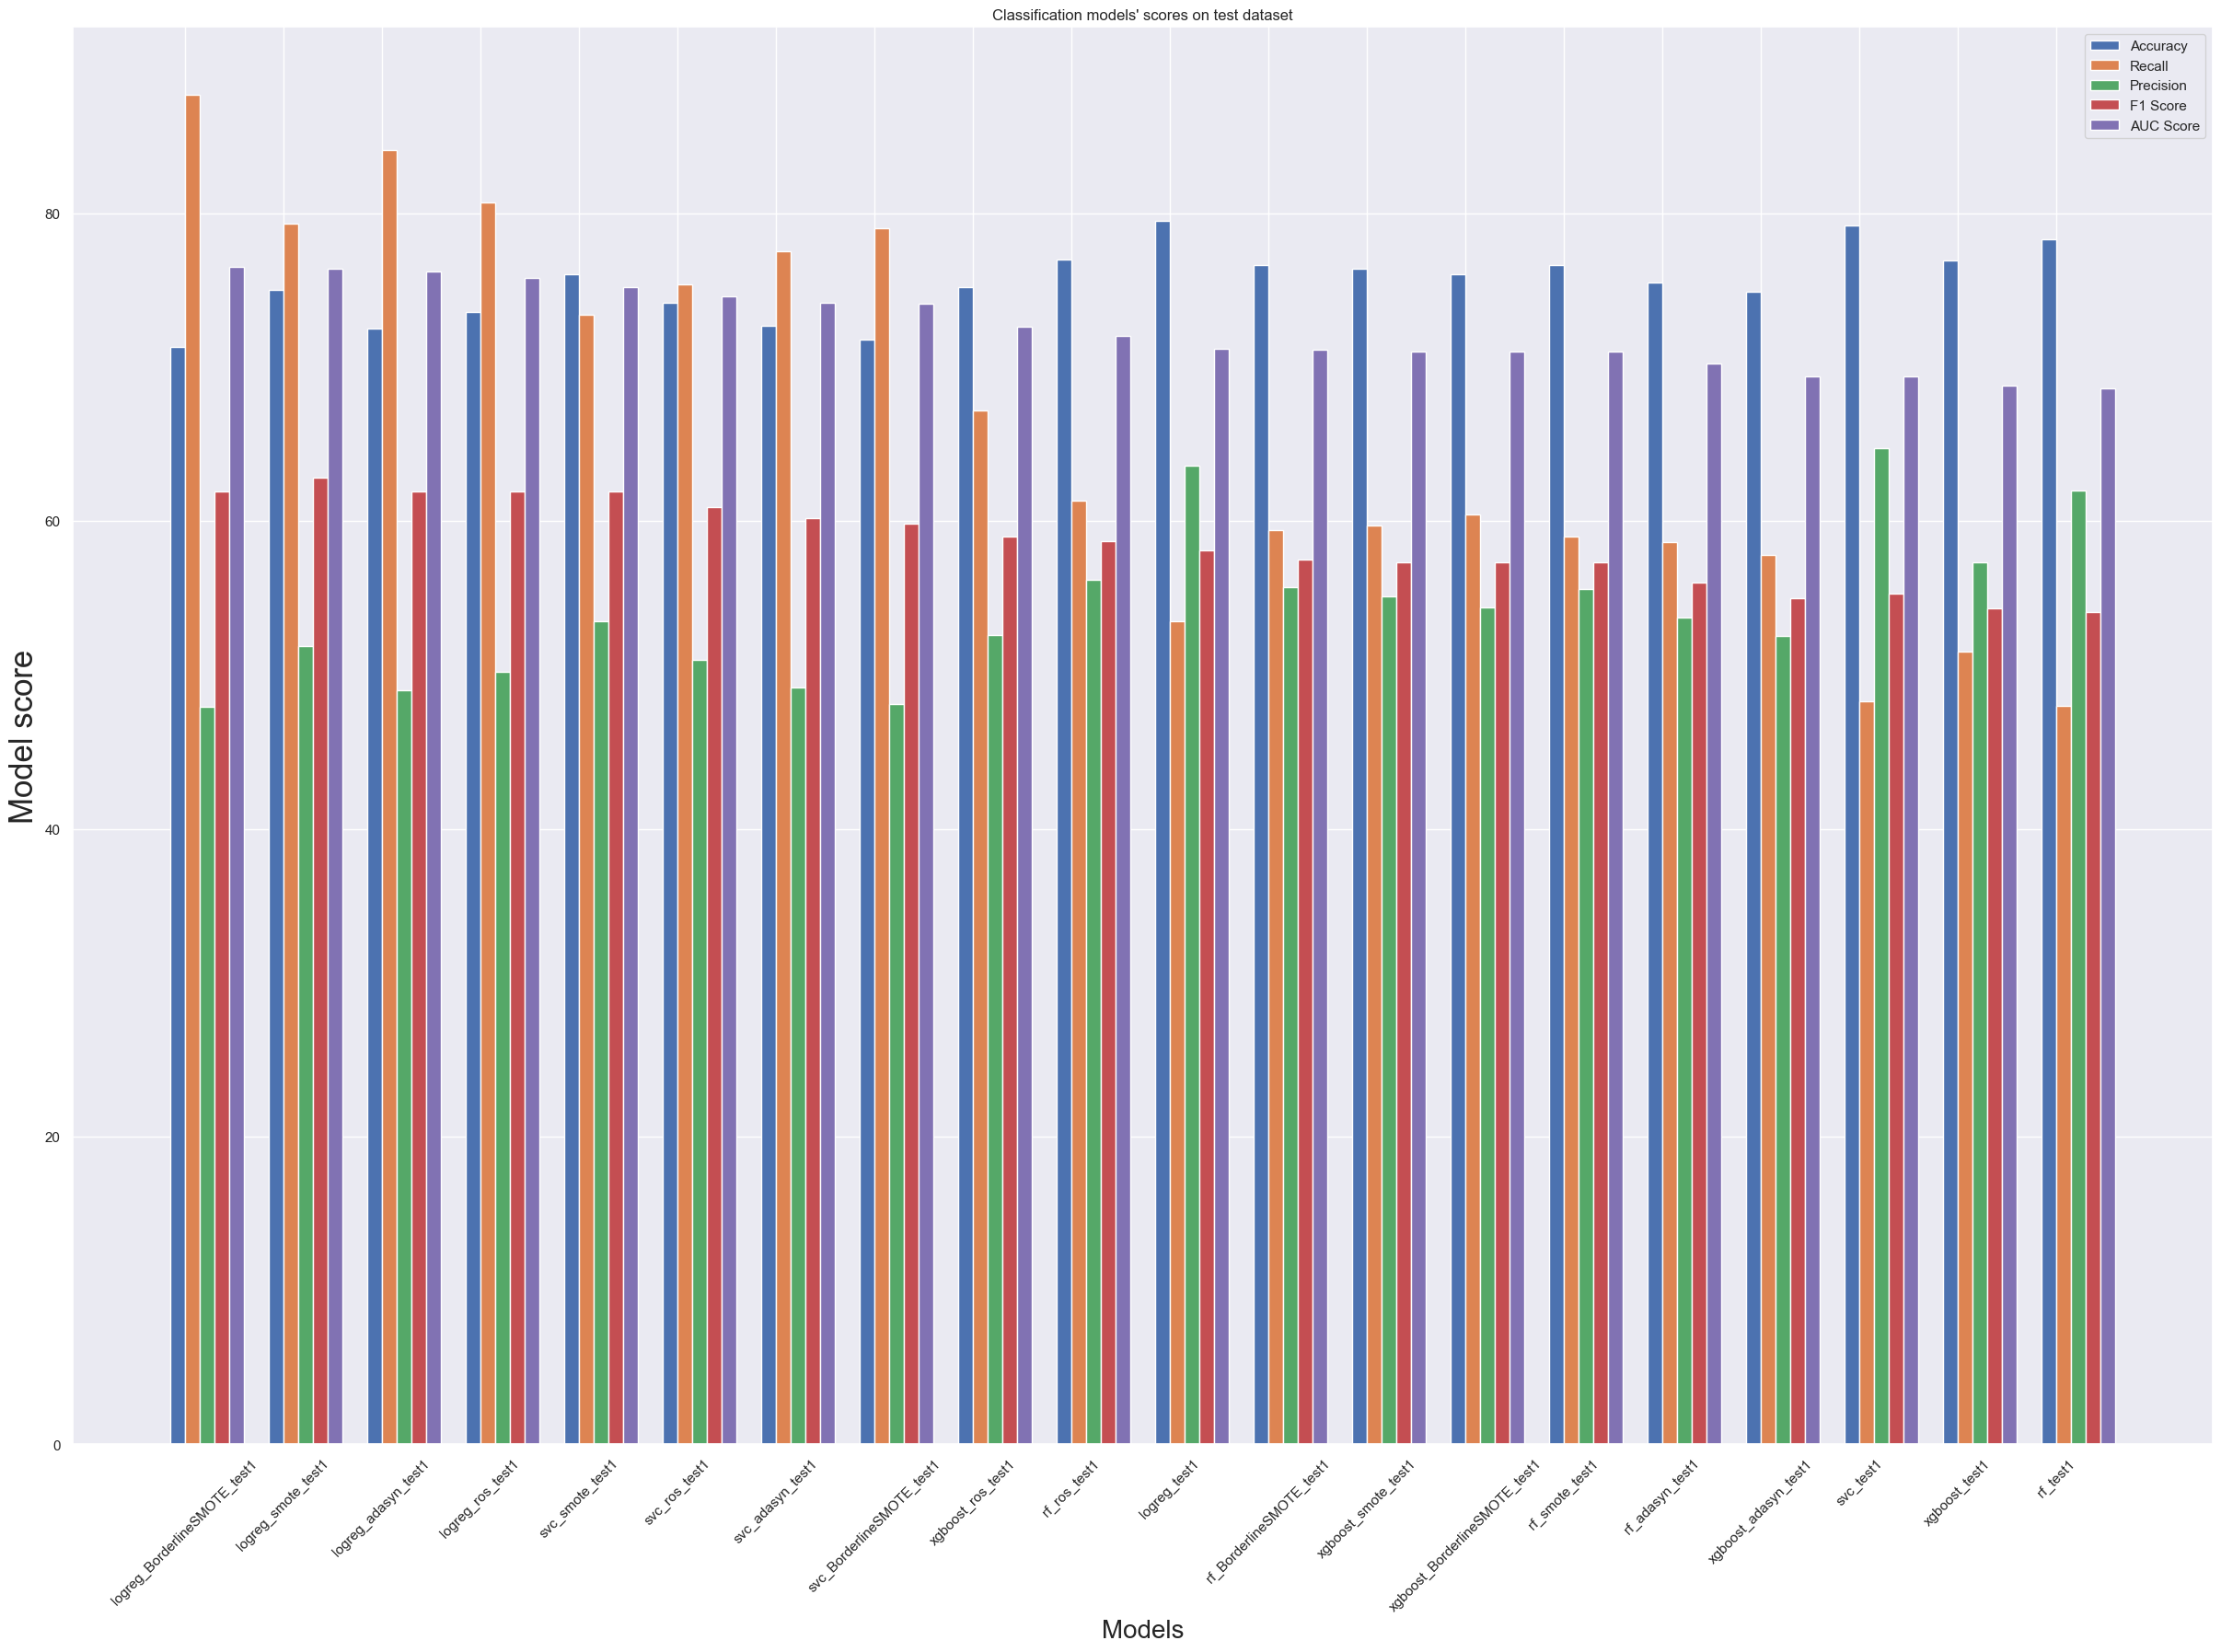

In [93]:
plt.figure(figsize=[30,20])
w=0.15
x=test_scores.modeller
a=test_scores.Accuracy
b=test_scores.Recall
c=test_scores.Precision
d=test_scores['F1 Score']
e=test_scores['AUC Score']


bar1 = np.arange(len(x))
bar2= [i + w for i in bar1]
bar3= [i + w for i in bar2]
bar4= [i + w for i in bar3]
bar5= [i + w for i in bar4]


plt.bar(bar1, a*100,w,label='Accuracy')
plt.bar(bar2, b*100,w,label='Recall')
plt.bar(bar3, c*100,w,label='Precision')
plt.bar(bar4, d*100,w,label='F1 Score')
plt.bar(bar5, e*100,w,label='AUC Score')




plt.xlabel('Models', fontsize=20)
plt.ylabel('Model score', fontsize=25)
plt.title('Classification models\' scores on test dataset')
plt.xticks(bar1+w/2,x, rotation = 45)
plt.legend()
plt.savefig("Modelbasarisi.png")

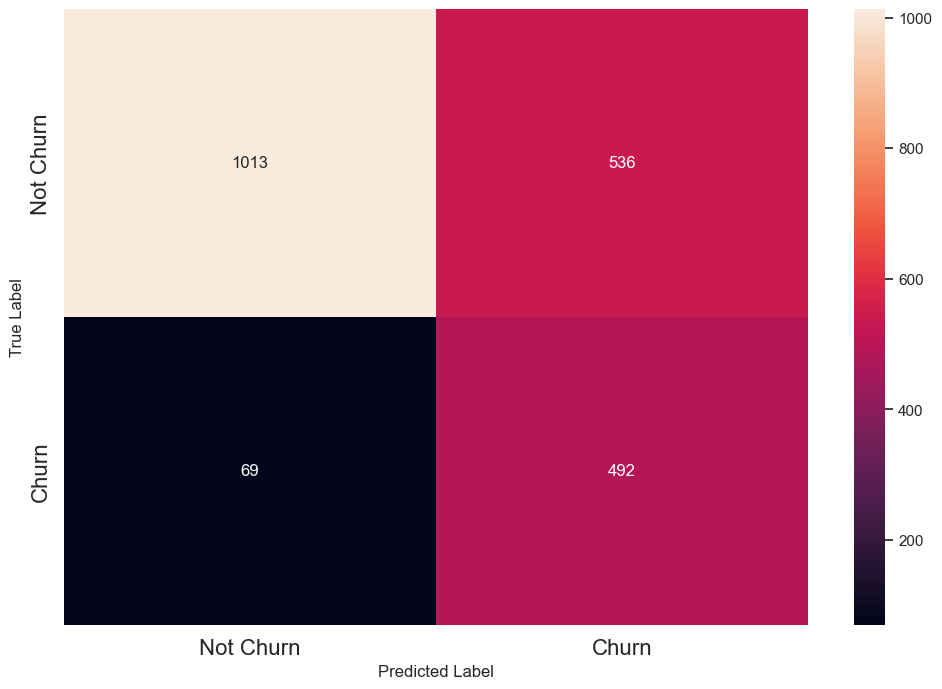

In [94]:
print_confusion_matrix(confusion_matrix(y_test, logreg_BorderlineSMOTE.predict(x_test_scaled)), ['Not Churn', 'Churn'])
plt.savefig("logregborderlinesmoteconfusion.png")

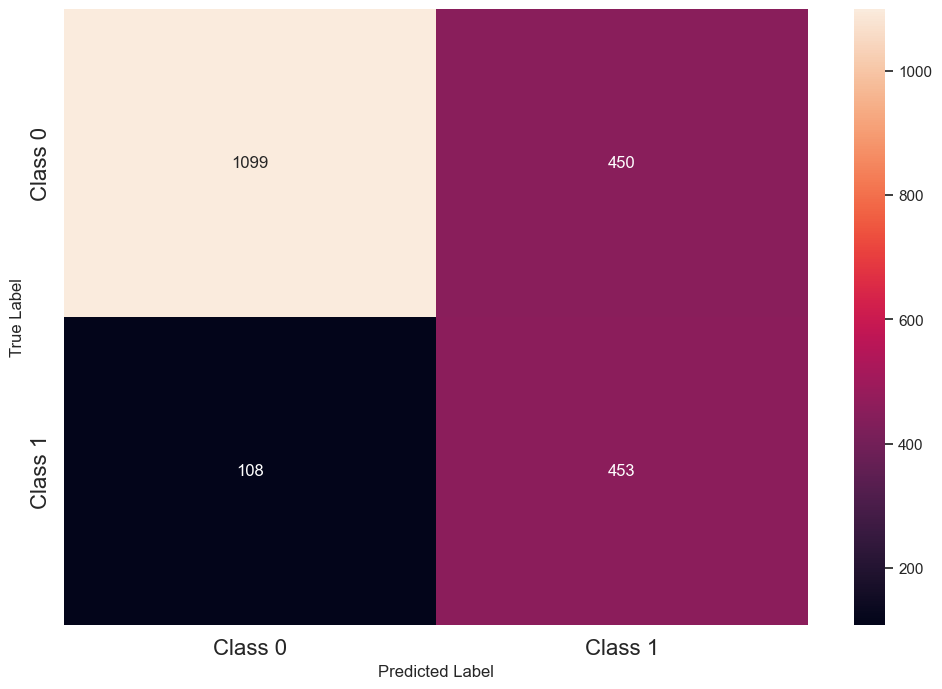

In [95]:
print_confusion_matrix(confusion_matrix(y_test, logreg_ros.predict(x_test_scaled)), ['Class 0', 'Class 1'])

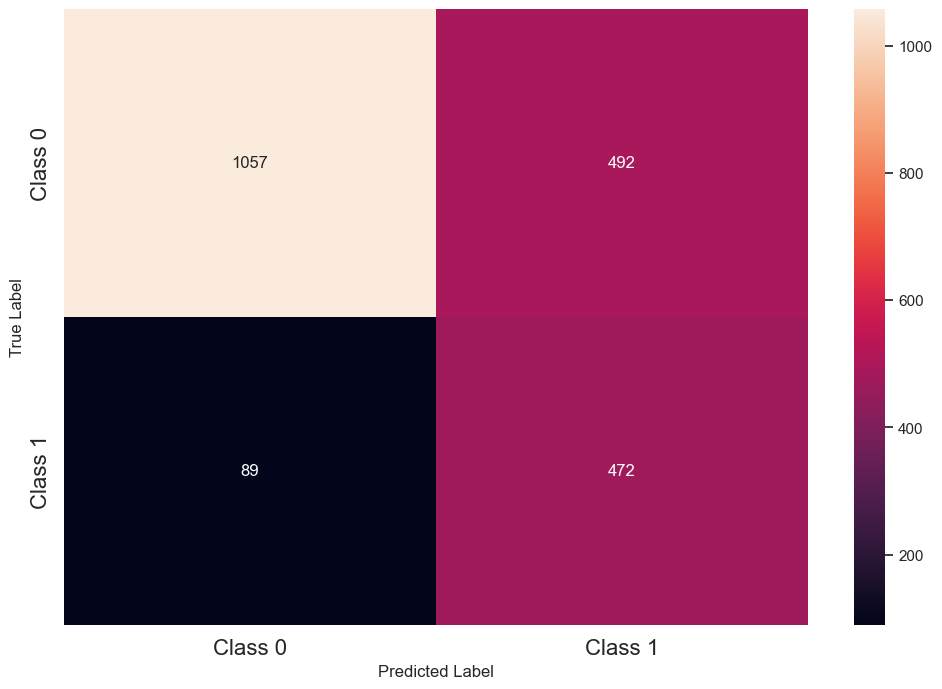

In [96]:
print_confusion_matrix(confusion_matrix(y_test, logreg_adasyn.predict(x_test_scaled)), ['Class 0', 'Class 1'])

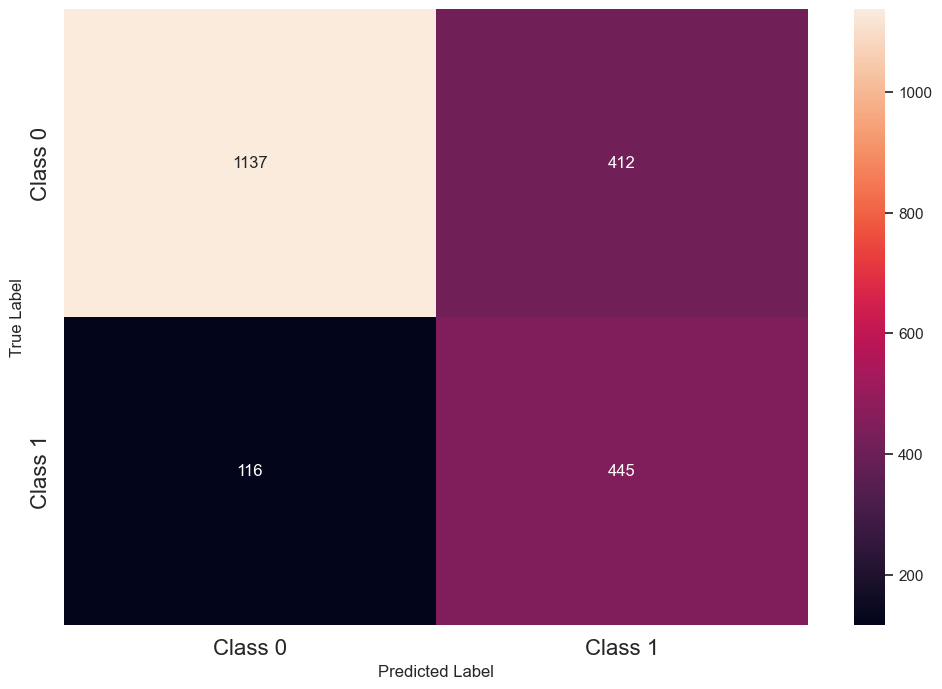

In [97]:
print_confusion_matrix(confusion_matrix(y_test, logreg_smote.predict(x_test_scaled)), ['Class 0', 'Class 1'])

In [98]:
train_scores.sort_values(by=['AUC Score'], ascending=False, inplace=True)

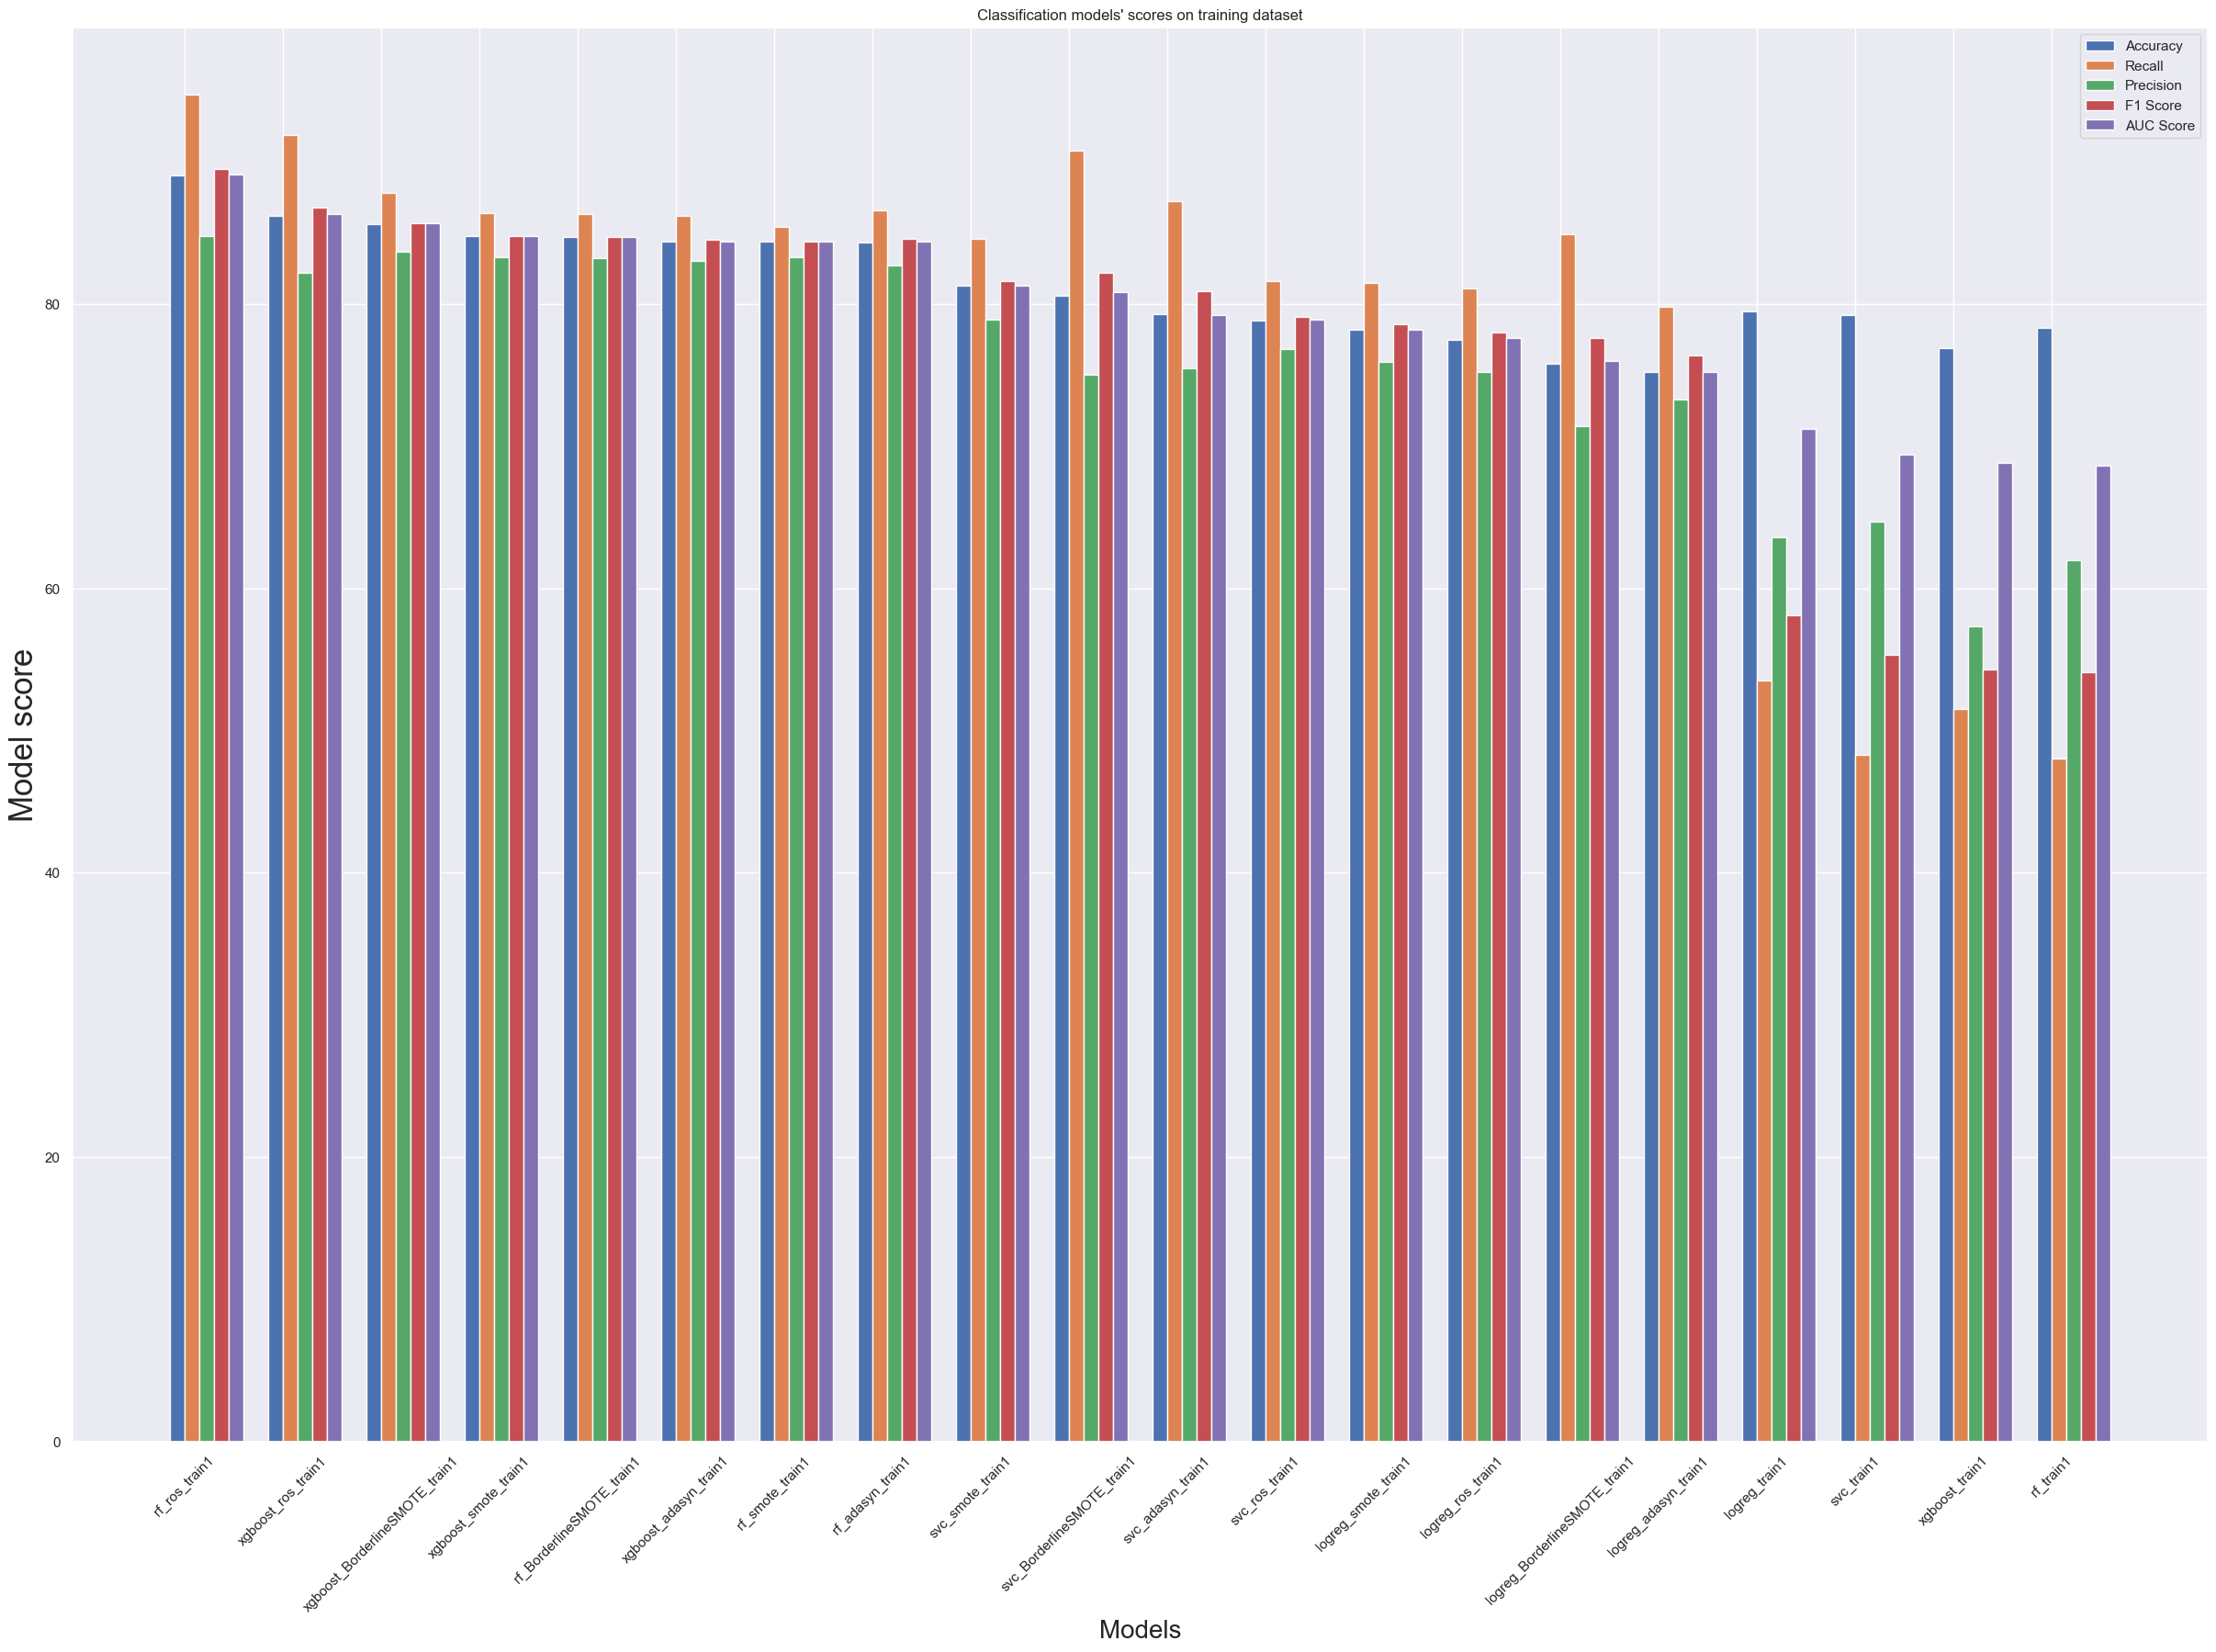

In [99]:
plt.figure(figsize=[30,20])
w=0.15
x=train_scores.modeller
a=train_scores.Accuracy
b=train_scores.Recall
c=train_scores.Precision
d=train_scores['F1 Score']
e=train_scores['AUC Score']


bar1 = np.arange(len(x))
bar2= [i + w for i in bar1]
bar3= [i + w for i in bar2]
bar4= [i + w for i in bar3]
bar5= [i + w for i in bar4]


plt.bar(bar1, a*100,w,label='Accuracy')
plt.bar(bar2, b*100,w,label='Recall')
plt.bar(bar3, c*100,w,label='Precision')
plt.bar(bar4, d*100,w,label='F1 Score')
plt.bar(bar5, e*100,w,label='AUC Score')




plt.xlabel('Models', fontsize=20)
plt.ylabel('Model score', fontsize=25)
plt.title('Classification models\' scores on training dataset')
plt.xticks(bar1+w/2,x, rotation = 45)
plt.legend()
plt.savefig("Modelbasarisitrain.png")


# GridSearchCV

In [101]:
logModel = LogisticRegression()
#     'solver' : ['lbfgs','newton-cg', 'newton-cholesky', 'liblinear','sag','saga'],'penalty' : ['l1', 'l2', 'elasticnet', None],


In [102]:


param_grid = [    
    {'solver' : ['lbfgs','newton-cg', 'newton-cholesky', 'liblinear','sag','saga'],
    'C' : np.logspace(-8, 8, 100),
    'penalty' : ['l1', 'l2', 'elasticnet', None],
    'max_iter' : [10, 100, 1000,2500, 5000, 10000],
    'multi_class' :['auto', 'ovr', 'multinomial']
    }
]



In [103]:
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [104]:
best_clf = clf.fit(xb_train,yb_train)

Fitting 5 folds for each of 43200 candidates, totalling 216000 fits


C:\Users\Ahoya\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
111000 fits failed out of a total of 216000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ahoya\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ahoya\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ahoya\anaconda3\Lib\site-packages\sklearn\linear

In [105]:


best_clf.best_estimator_



LogisticRegression(C=0.04229242874389508, max_iter=10, penalty=None,
                   solver='sag')

In [106]:
'''C=3.6783797718286344, max_iter=10, penalty=None,
                   solver='sag'''

"C=3.6783797718286344, max_iter=10, penalty=None,\n                   solver='sag"

In [107]:
logreg_borderlinesmote_grid = LogisticRegression(C=0.572236765935022, max_iter=10, penalty=None, solver='sag')  

In [108]:
logreg_borderlinesmote_grid.fit(xb_train, yb_train)

C:\Users\Ahoya\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Ahoya\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.572236765935022, max_iter=10, penalty=None, solver='sag')

Text(0.5, 1.0, 'Logistic Regression borderlineSMOTE & GridSearch')

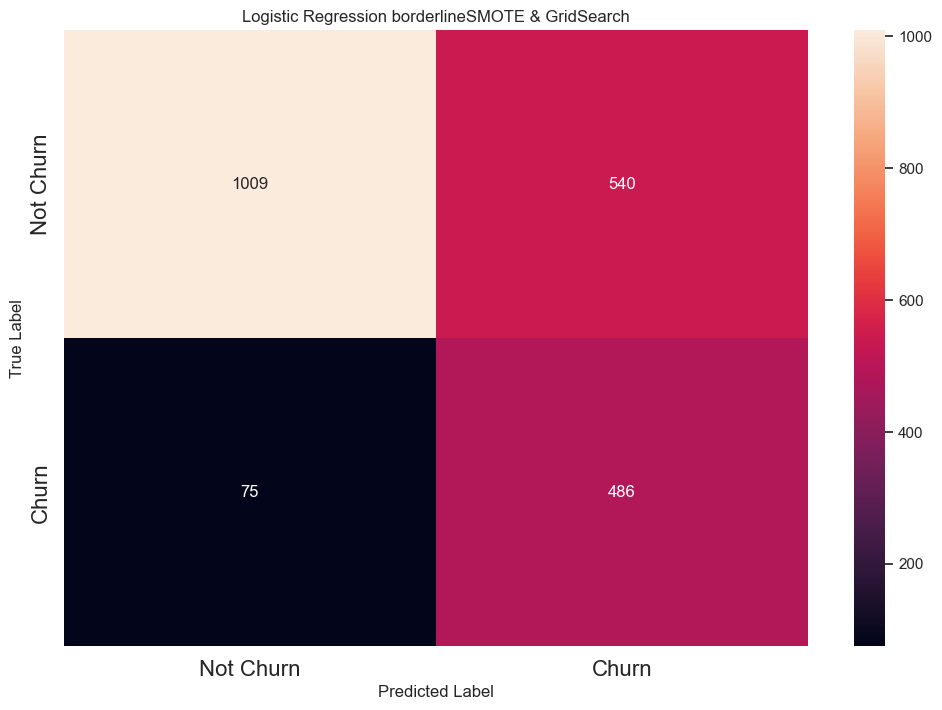

In [109]:
print_confusion_matrix(confusion_matrix(y_test, logreg_borderlinesmote_grid.predict(x_test_scaled)), ['Not Churn', 'Churn'])
plt.title('Logistic Regression borderlineSMOTE & GridSearch')
#plt.savefig("logreggridconfusion.png")

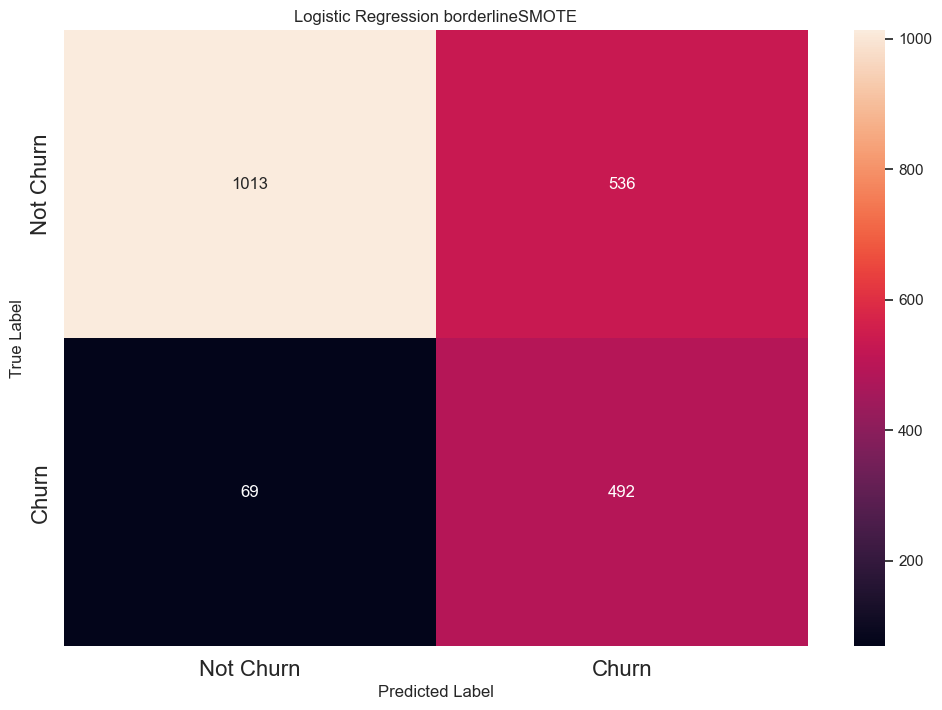

In [110]:
print_confusion_matrix(confusion_matrix(y_test, logreg_BorderlineSMOTE.predict(x_test_scaled)), ['Not Churn', 'Churn'])
plt.title('Logistic Regression borderlineSMOTE')
plt.savefig("logregborderlinesmoteconfusion.png")

In [111]:
evaluate_model(logreg_BorderlineSMOTE, x_test_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,0.713,0.877,0.479,0.619,0.765


In [112]:
evaluate_model(logreg_borderlinesmote_grid, x_test_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
"LogisticRegression(C=0.572236765935022, max_iter=10, penalty=None, solver='sag')Class 1",0.709,0.866,0.474,0.612,0.759


In [113]:
print (f'Accuracy - : {best_clf.score(x_test_scaled,y_test):.3f}')

Accuracy - : 0.718


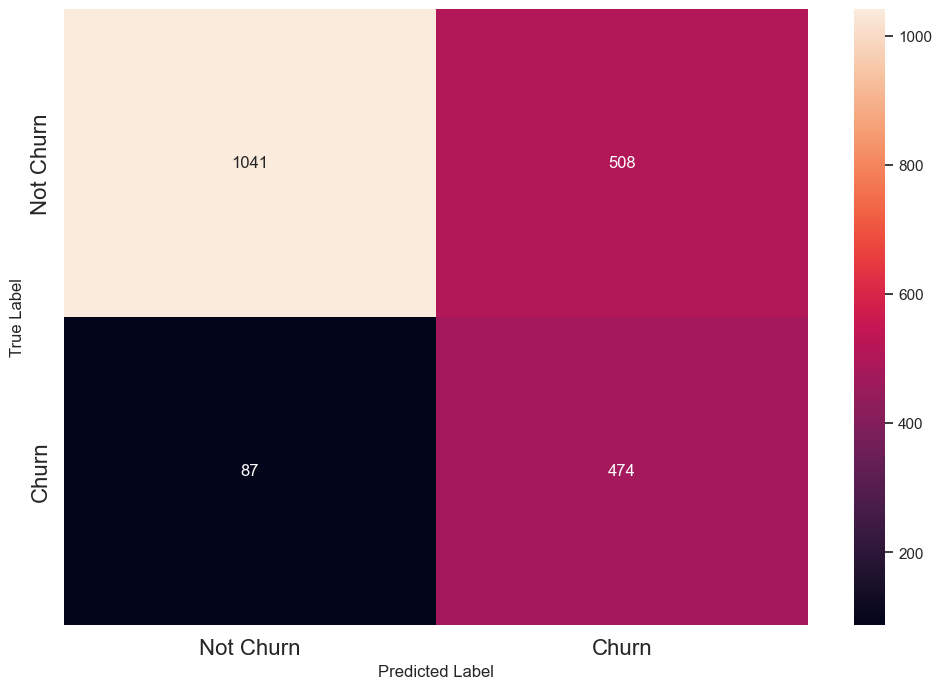

In [114]:
print_confusion_matrix(confusion_matrix(y_test, best_clf.predict(x_test_scaled)), ['Not Churn', 'Churn'])
#plt.savefig("logreggridconfusion.png")


In [115]:
evaluate_model(best_clf, x_test_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
"GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,\n param_grid=[{'C': array([1.00000000e-08, 1.45082878e-08, 2.10490414e-08, 3.05385551e-08,\n 4.43062146e-08, 6.42807312e-08, 9.32603347e-08, 1.35304777e-07,\n 1.96304065e-07, 2.84803587e-07, 4.13201240e-07, 5.99484250e-07,\n 8.69749003e-07, 1.26185688e-06, 1.83073828e-06, 2.65608778e-06,\n 3.85352859e-06, 5.59081018e-...\n 1.66810054e+06, 2.42012826e+06, 3.51119173e+06, 5.09413801e+06,\n 7.39072203e+06, 1.07226722e+07, 1.55567614e+07, 2.25701972e+07,\n 3.27454916e+07, 4.75081016e+07, 6.89261210e+07, 1.00000000e+08]),\n 'max_iter': [10, 100, 1000, 2500, 5000, 10000],\n 'multi_class': ['auto', 'ovr', 'multinomial'],\n 'penalty': ['l1', 'l2', 'elasticnet', None],\n 'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',\n 'liblinear', 'sag', 'saga']}],\n verbose=True)Class 1",0.718,0.845,0.483,0.614,0.758


In [116]:
evaluate_model(logreg_BorderlineSMOTE, x_test_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,0.713,0.877,0.479,0.619,0.765


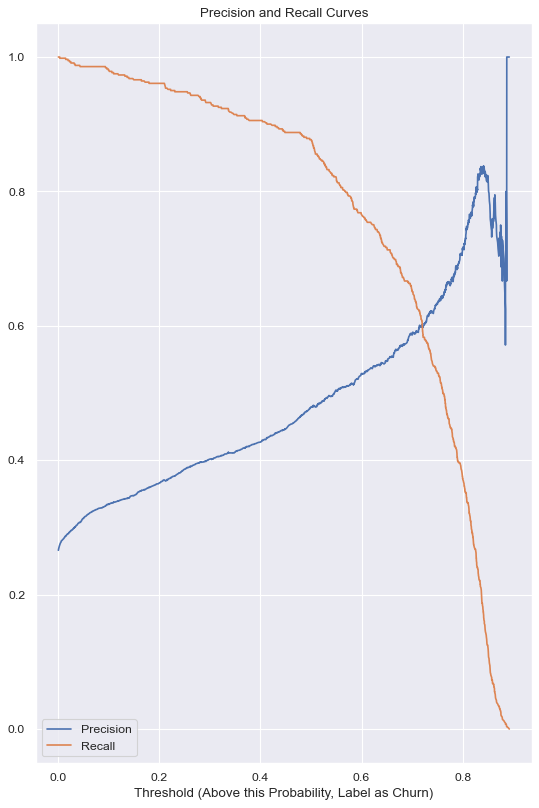

In [117]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logreg_BorderlineSMOTE.predict_proba(x_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='Precision')
plt.plot(threshold_curve, recall_curve[1:], label='Recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (Above this Probability, Label as Churn)');
plt.title('Precision and Recall Curves');

ROC AUC Score= 0.837


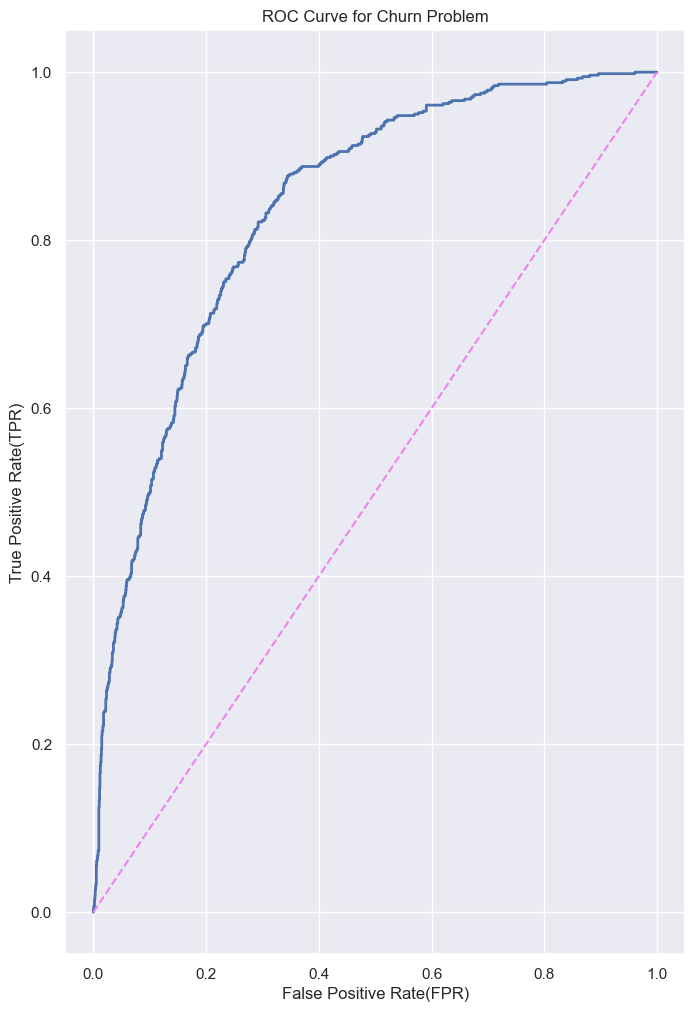

In [118]:
fpr, tpr, thresholds = roc_curve(y_test, logreg_BorderlineSMOTE.predict_proba(x_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC Curve for Churn Problem');
print("ROC AUC Score=", round(roc_auc_score(y_test, logreg_BorderlineSMOTE.predict_proba(x_test_scaled)[:,1]),3))

In [119]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2', None]
# Maximum number of levels in tree
max_depth = [2,4,6,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
max_leaf_nodes = [3, 6, 9]

In [120]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'max_leaf_nodes' : max_leaf_nodes}
print(param_grid)

{'n_estimators': [10, 25, 41, 56, 72, 87, 103, 118, 134, 150], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [2, 4, 6, 8], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False], 'max_leaf_nodes': [3, 6, 9]}


In [121]:
rf_Model = RandomForestClassifier()

In [122]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)

In [123]:
rf_Grid.fit(x_train, y_train)

Fitting 3 folds for each of 3840 candidates, totalling 11520 fits


C:\Users\Ahoya\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 25, 41, 56, 72, 87, 103, 118, 134,
                                          150]},
             verbose=2)

In [124]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 41}

In [125]:
rf_ros= RandomForestClassifier(bootstrap= True,
 max_depth=4,
 max_features='sqrt',
 min_samples_leaf =2,
 min_samples_split= 5,
 n_estimators= 25)  

In [126]:
rf_Grid.fit(xr_train_rf, yr_train_rf)

Fitting 3 folds for each of 3840 candidates, totalling 11520 fits


C:\Users\Ahoya\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 25, 41, 56, 72, 87, 103, 118, 134,
                                          150]},
             verbose=2)

In [127]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 134}

In [128]:
rf_ros= RandomForestClassifier(bootstrap= True,
 max_depth=6,
 max_features= None,
 max_leaf_nodes = 9,
 min_samples_leaf =2,
 min_samples_split= 5,
 n_estimators= 25)  

In [129]:
rf_ros.fit(xr_train_rf, yr_train_rf)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=25)

In [130]:
print (f'Train Accuracy - : {rf_ros.score(xr_train_rf,yr_train_rf):.3f}')


Train Accuracy - : 0.772


In [131]:
print (f'Train Accuracy - : {rf_ros.score(xr_test_rf,yr_test_rf):.3f}')


Train Accuracy - : 0.774


In [132]:
print (f'Test Accuracy - : {rf_Grid.score(xr_test_rf,yr_test_rf):.3f}')

Test Accuracy - : 0.774


In [133]:
print (f'Test Accuracy - : {rf_Grid.score(x_test,y_test):.3f}')

Test Accuracy - : 0.738


In [134]:
evaluate_model(rf_ros, x_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
"RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,\n min_samples_leaf=2, min_samples_split=5,\n n_estimators=25)Class 1",0.742,0.743,0.51,0.605,0.743


In [135]:
rf_ros_grid_test1 = evaluate_model(rf_Grid, x_test, y_test, pred_label=1)
rf_ros_grid_test1

,Accuracy,Recall,Precision,F1 Score,AUC Score
"GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,\n param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6, 8],\n 'max_features': ['auto', 'sqrt', 'log2', None],\n 'max_leaf_nodes': [3, 6, 9],\n 'min_samples_leaf': [1, 2],\n 'min_samples_split': [2, 5],\n 'n_estimators': [10, 25, 41, 56, 72, 87, 103, 118, 134,\n 150]},\n verbose=2)Class 1",0.738,0.788,0.505,0.615,0.754


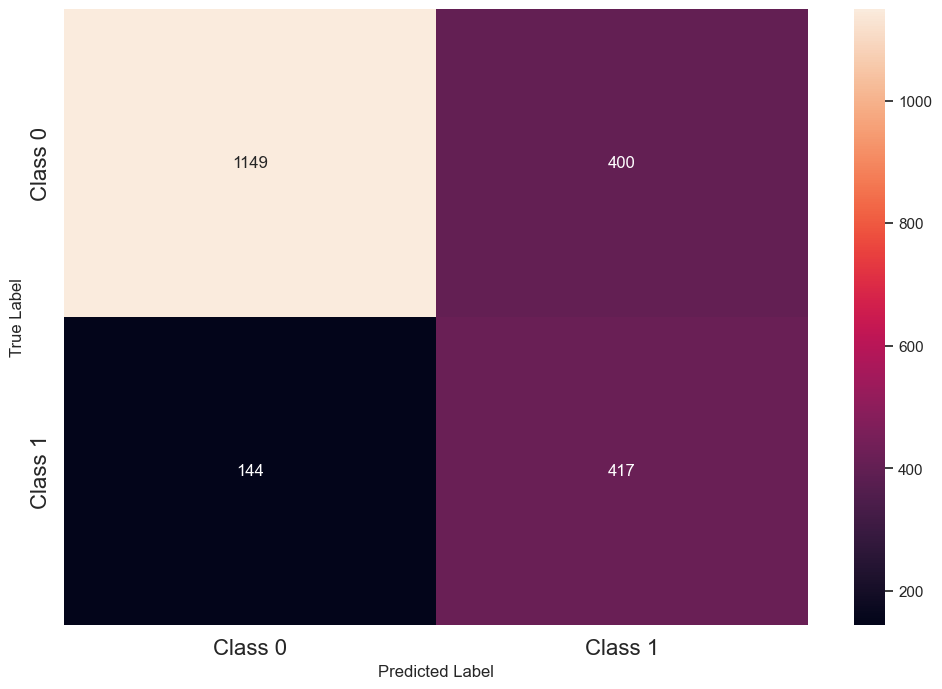

In [136]:
print_confusion_matrix(confusion_matrix(y_test, rf_ros.predict(x_test)), ['Class 0', 'Class 1'])

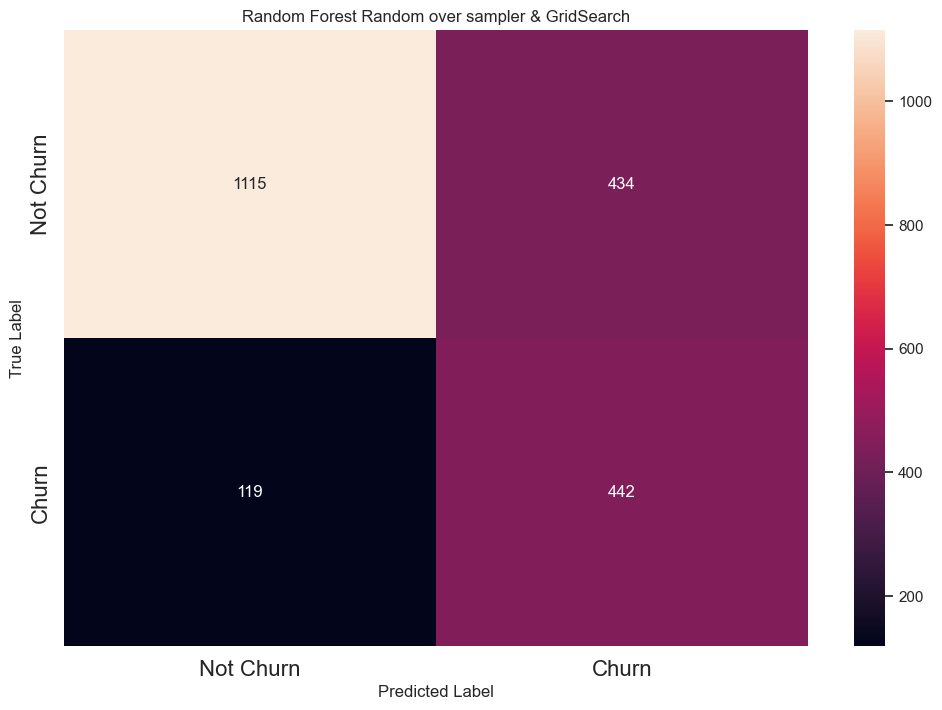

In [138]:
print_confusion_matrix(confusion_matrix(y_test, rf_Grid.predict(x_test)), ['Not Churn', 'Churn']) ############ rf ros hypermeter tuned
plt.title('Random Forest Random over sampler & GridSearch')

plt.savefig("rfrosgrid.png")


In [140]:
rf_gridsearchcv = pd.concat([rf_ros_test1, rf_ros_grid_test1], axis=0)
rf_gridsearchcv

,Accuracy,Recall,Precision,F1 Score,AUC Score
RandomForestClassifier()Class 1,0.770,0.613,0.562,0.587,0.720
"GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,\n param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6, 8],\n 'max_features': ['auto', 'sqrt', 'log2', None],\n 'max_leaf_nodes': [3, 6, 9],\n 'min_samples_leaf': [1, 2],\n 'min_samples_split': [2, 5],\n 'n_estimators': [10, 25, 41, 56, 72, 87, 103, 118, 134,\n 150]},\n verbose=2)Class 1",0.738,0.788,0.505,0.615,0.754


In [142]:
logreg_borderlinesmote_grid_test1 = evaluate_model(logreg_borderlinesmote_grid, x_test_scaled, y_test, pred_label=1)
logreg_borderlinesmote_grid_test1

,Accuracy,Recall,Precision,F1 Score,AUC Score
"LogisticRegression(C=0.572236765935022, max_iter=10, penalty=None, solver='sag')Class 1",0.709,0.866,0.474,0.612,0.759


In [144]:
logreg_gridsearchcv = pd.concat([logreg_BorderlineSMOTE_test1, rf_ros_grid_test1], axis=0)
logreg_gridsearchcv

,Accuracy,Recall,Precision,F1 Score,AUC Score
LogisticRegression(solver='liblinear')Class 1,0.713,0.877,0.479,0.619,0.765
"GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,\n param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6, 8],\n 'max_features': ['auto', 'sqrt', 'log2', None],\n 'max_leaf_nodes': [3, 6, 9],\n 'min_samples_leaf': [1, 2],\n 'min_samples_split': [2, 5],\n 'n_estimators': [10, 25, 41, 56, 72, 87, 103, 118, 134,\n 150]},\n verbose=2)Class 1",0.738,0.788,0.505,0.615,0.754


In [146]:
evaluate_model(best_clf, x_test_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
"GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,\n param_grid=[{'C': array([1.00000000e-08, 1.45082878e-08, 2.10490414e-08, 3.05385551e-08,\n 4.43062146e-08, 6.42807312e-08, 9.32603347e-08, 1.35304777e-07,\n 1.96304065e-07, 2.84803587e-07, 4.13201240e-07, 5.99484250e-07,\n 8.69749003e-07, 1.26185688e-06, 1.83073828e-06, 2.65608778e-06,\n 3.85352859e-06, 5.59081018e-...\n 1.66810054e+06, 2.42012826e+06, 3.51119173e+06, 5.09413801e+06,\n 7.39072203e+06, 1.07226722e+07, 1.55567614e+07, 2.25701972e+07,\n 3.27454916e+07, 4.75081016e+07, 6.89261210e+07, 1.00000000e+08]),\n 'max_iter': [10, 100, 1000, 2500, 5000, 10000],\n 'multi_class': ['auto', 'ovr', 'multinomial'],\n 'penalty': ['l1', 'l2', 'elasticnet', None],\n 'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',\n 'liblinear', 'sag', 'saga']}],\n verbose=True)Class 1",0.718,0.845,0.483,0.614,0.758


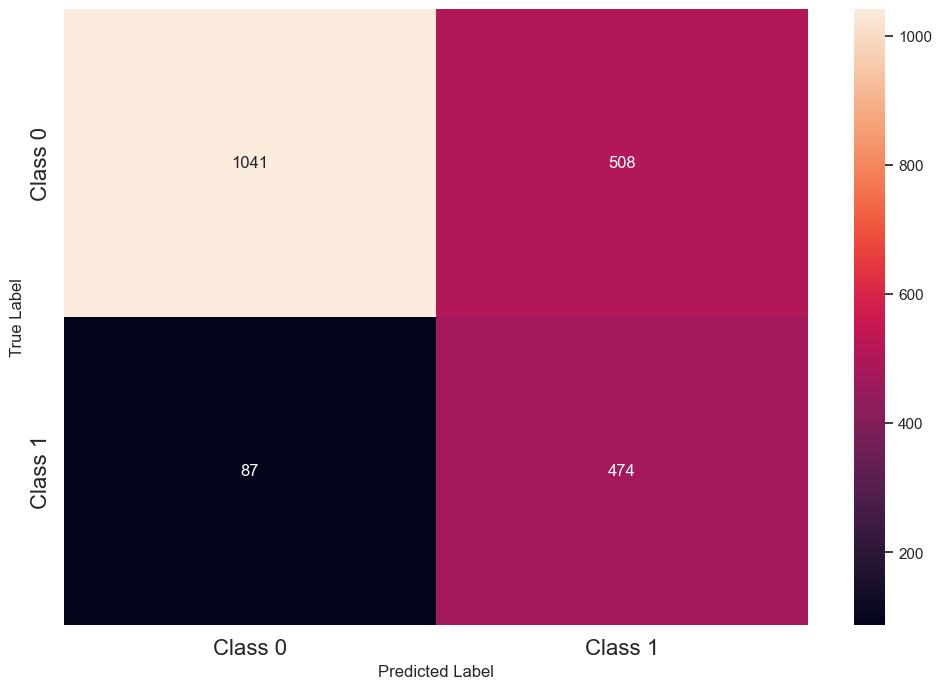

In [148]:
print_confusion_matrix(confusion_matrix(y_test, best_clf.predict(x_test_scaled)), ['Class 0', 'Class 1'])

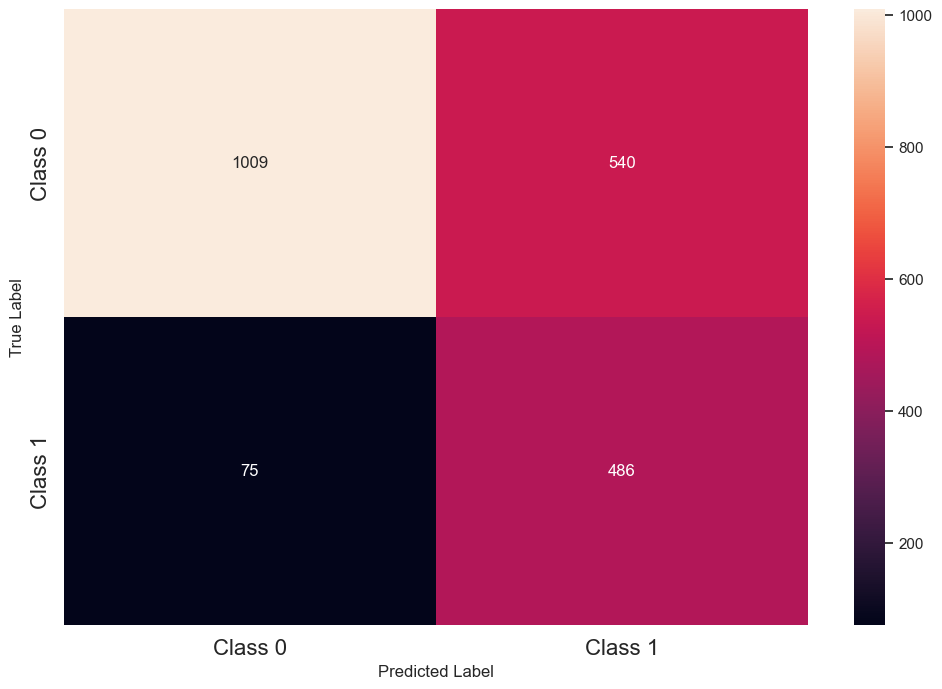

In [150]:
print_confusion_matrix(confusion_matrix(y_test, logreg_borderlinesmote_grid.predict(x_test_scaled)), ['Class 0', 'Class 1'])

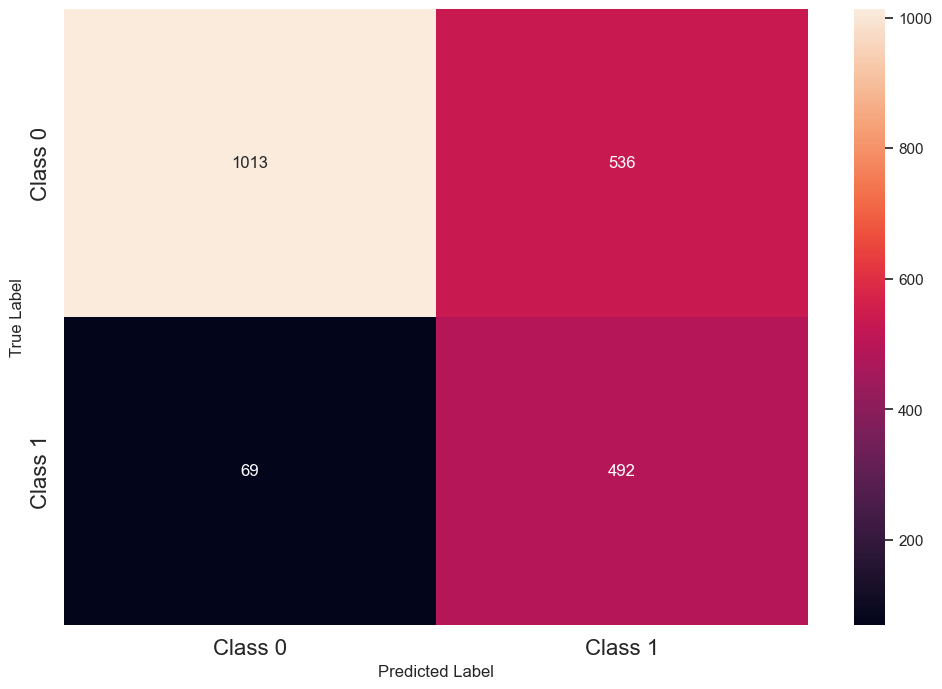

In [152]:
print_confusion_matrix(confusion_matrix(y_test, logreg_BorderlineSMOTE.predict(x_test_scaled)), ['Class 0', 'Class 1'])

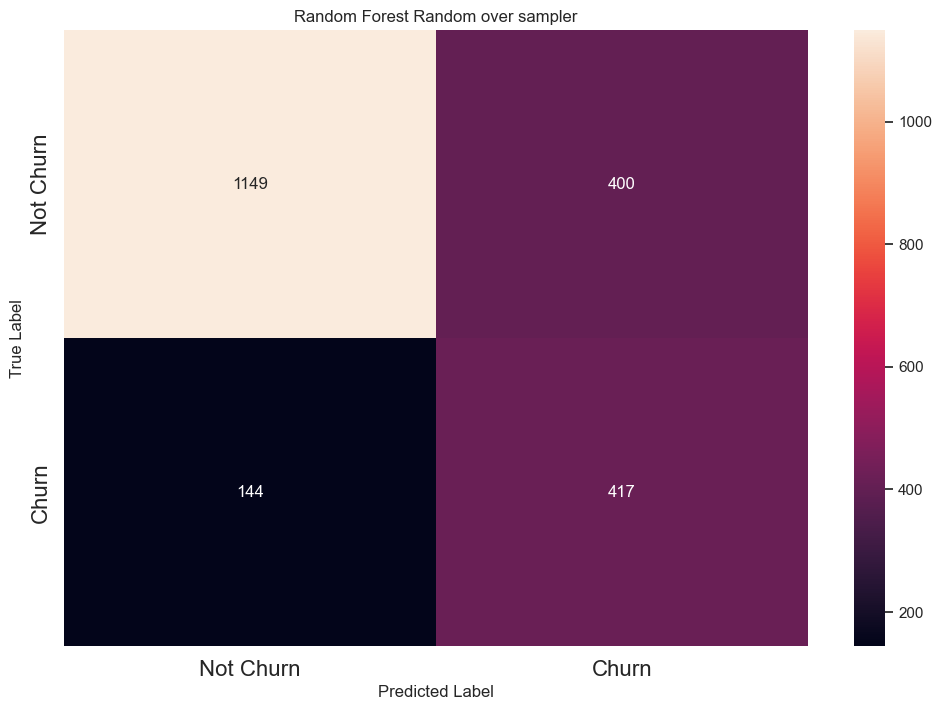

In [154]:
print_confusion_matrix(confusion_matrix(y_test, rf_ros.predict(x_test)), ['Not Churn', 'Churn'])
plt.title('Random Forest Random over sampler')
plt.savefig("rfros_confusion.png")

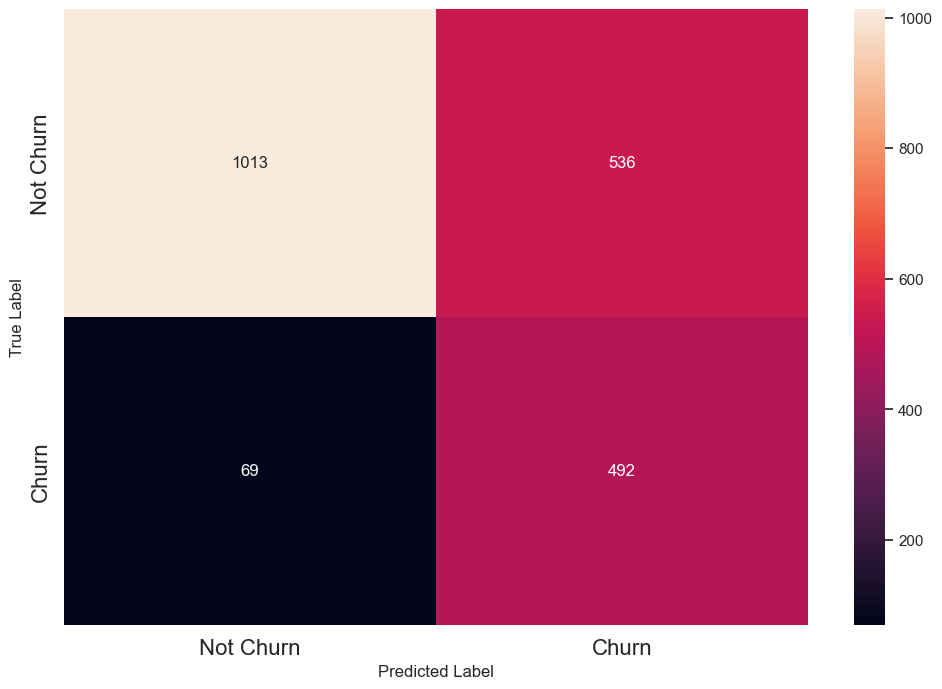

In [156]:
print_confusion_matrix(confusion_matrix(y_test, logreg_BorderlineSMOTE.predict(x_test_scaled)), ['Not Churn', 'Churn'])
